## TODOs
- SS's on easy maps with low OD will become so-so score after OD normalization, which will buff easy map's difficulty.
- Empty entries
- Remove maps with low player counts
- Consider play counts

## Dependencies
- ossapi
- pytorch
- numpy
- plotly
- pandas
- chart_studio

In [1]:
from ossapi import *
import copy

In [2]:
import os
api = OssapiV2(int(os.environ['OSUAPIv2_APP_ID']), os.environ['OSUAPIv2_APP_SECRET'], os.environ['OSUAPIv2_APP_CALLBACK'])
apiv1 = Ossapi(os.environ['OSUAPIv1_KEY'])

In [3]:
# Util functions
from scipy import special
import math

def GoodRateToStddev(goodRate, timewindow_300_ms):
    return (timewindow_300_ms) / (special.erfinv(1 - goodRate) * 2 * math.sqrt(2.0))

def StddevToGoodRate(stddev, timewindow_300_ms):
    return 1.0 - special.erf((timewindow_300_ms / 2) / (stddev * math.sqrt(2)))

# I really don't know how this works.
# Just use this, not that bad ;w;
def ODToTimewindow(OD):
    raw = 99 - int(2 * (OD / 0.333))
    return raw - (raw + 1) % 2

def ScoreConvert(nP, nG, nM, OD, refOD = 10.0):
    
    # well, we cares about 9.8 tho
    if OD == 9.8 and refOD == 10.0:
        return (nP, nG, nM)
    
    goodRate = (nG) / (nP + nG)
    if goodRate <= 0:
        goodRate = 0.6 / (nP + nG + nM)
    goodRateNew = StddevToGoodRate(GoodRateToStddev(goodRate, ODToTimewindow(OD)), ODToTimewindow(refOD))
    
    # nGname (?
    nGnew = round(goodRateNew * (nP + nG))
    return ((nP + nG - nGnew), nGnew, nM)

# 300: +- 31.5ms (63.0ms)
# 36x 100 (4.489 %)
# UR 149.03
print("UR: %f" % (10 * GoodRateToStddev(0.04489, 63))) # Gives 167.27, not sure what to do ...
print("UR: %f" % (10 * GoodRateToStddev(0.001, 50))) # 我是觉得按照街机25ms的判定，要算3个标准差的话，全良选手UR不能超过80，感觉不太对

print(ODToTimewindow(8.4) / 2.0) # Should be 19.5 but who caresssssssssssssss fk

print(ScoreConvert(1190, 0, 0, 6, 8.4))

UR: 157.053673
UR: 75.975678
24.5
(1182, 8, 0)


In [6]:
import torch
from tqdm.notebook import tqdm

def get_acc(c_300, c_100, c_miss):
    total = c_300 + c_100 + c_miss
    acc = (c_300 + 0.5 * c_100) / total
    return acc

class PlayerMapPool:
    
    def __init__(self):
        self.players = {}
        self.maps = {}
        self.refOD = 10.0
        
    def GetScoreObject(self, bid, mods, count_300, count_100, count_miss):
        
        # TODO: OD normalization
        scoreObj = {
            'bid': bid,
            'accuracy': get_acc(count_300, count_100, count_miss),
            'p': count_300,
            'g': count_100,
            'm': count_miss,
            'mods': mods if isinstance(mods, str) else mods.short_name()
        }
        
        return scoreObj
    
    def AddMapToPlayer(self, scoreObj, uid):
        
        exist = False
        for i, m in enumerate(self.players[repr(uid)]["maps"]):
            if m['bid'] == scoreObj['bid']:
                exist = True
                if m['accuracy'] < scoreObj['accuracy']:
                    self.players[repr(uid)]["maps"][i] = scoreObj

        if not exist:
            self.players[repr(uid)]["maps"].append(scoreObj)
        
        return not exist
        
    def AddMap(self, bid):
        
        if repr(bid) in self.maps:
            print("Map bid=%s already exists in the dataset." % (bid))
            return
        
        affected = 0
        
        # NoMod / HD, Taiko, Top 100
        scores = apiv1.get_scores(bid, mode=1, mods=0, limit=100)
        scores += apiv1.get_scores(bid, mode=1, mods=8, limit=100) # HD
        mapdata = api.beatmap(bid)
        
        self.maps[repr(bid)] = mapdata
        
        for score in scores:
            
            affect = False
            
            # New player
            if repr(score.user_id) not in self.players:
                self.players[repr(score.user_id)] = {
                    'id': score.user_id,
                    'name': score.username,
                    'maps': []
                }
                affect = True
            
            scoreObj = self.GetScoreObject(bid, score.mods, score.count_300, score.count_100, score.count_miss)
            
            affect = self.AddMapToPlayer(scoreObj, score.user_id) or affect
            
            if affect:
                affected += 1
        
        print("Updated %d players for Map bid=%s." % (affected, bid))
        print("Currently %d players and %d maps in dataset." % (len(self.players), len(self.maps)))
        
    def Store(self, path = "dataset.pkl"):
        torch.save([self.players, self.maps], path)
        print("Dataset saved to %s with %d maps, %d players." % (path, len(self.maps), len(self.players)))
        
    def LoadFrom(self, path):
        if not os.path.exists(path):
            print("File %s not found." % path)
            return
        self.players, self.maps = torch.load(path)
        print("Dataset loaded from %s with %d maps, %d players." % (path, len(self.maps), len(self.players)))
        
    def FillBPScores(self):
        
        pcnt = 0
        
        # Iterate through all players
        for p in self.players:
            
            cnt = 0
            pcnt += 1
            
            # Get BP
            best = apiv1.get_user_best(self.players[p]['id'], limit = 100, mode = 1)
            
            # For all maps in BP
            for b in best:
                
                # Only update if the map already in dataset (don't add new maps)
                if repr(b.beatmap_id) in self.maps:
                    
                    # Check mods to ignore DT / HR / FL scores
                    mods = b.mods.decompose()
                    if Mod.DT not in mods and Mod.NC not in mods and Mod.HR not in mods and Mod.FL not in mods:
                        
                        # Update player score
                        scoreObj = self.GetScoreObject(b.beatmap_id, b.mods, b.count_300, b.count_100, b.count_miss)
                        self.AddMapToPlayer(scoreObj, self.players[p]['id'])
                        
                        cnt += 1
            
            print("Updated %20s's Best Performances with %3d entries (%5d / %5d)" % (self.players[p]['name'], cnt, pcnt, len(self.players)))
        
    def Filter(self, minimum_maps = 2):
        
        removed = []
        self.raw_players = copy.deepcopy(self.players)
        
        for player in self.players:
            if(len(self.players[player]["maps"]) < minimum_maps):
                removed.append(player)
        
        for r in removed:
            del self.players[r]
            
        print("Filtering out players with less than %d maps play records." % minimum_maps)
        print("Currently %d players and %d maps in dataset." % (len(self.players), len(self.maps)))
        
    def ConvertAllToRefOD(self):
        
        for uid in tqdm(self.players):
            for i, m in enumerate(self.players[uid]["maps"]):
                
                if 'refOD' in self.players[uid]["maps"][i]:
                    continue
                
                od = self.maps[repr(m['bid'])].accuracy
                scoreObj = self.GetScoreObject(
                    m['bid'],
                    m['mods'],
                    *ScoreConvert(m['p'], m['g'], m['m'], od, self.refOD)
                )
                scoreObj['refOD'] = self.refOD
                self.players[uid]["maps"][i] = scoreObj

In [7]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")
pool.ConvertAllToRefOD()

File dataset.pkl not found.


0it [00:00, ?it/s]

In [8]:
pool.Store("dataset.pkl")

Dataset saved to dataset.pkl with 0 maps, 0 players.


In [9]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")

pool.AddMap(1921771) # ♡ Lie [False]
pool.AddMap(1012367) # ♡ Cross The Finish Line [Inner Oni]
pool.AddMap(1549622) # ♡ Katagiri [Katagiri]
pool.AddMap(2454551) # R LvC3 [Hell Oni]
pool.AddMap(1714380) # R Dizzolve [goheegy's Inner Oni]
pool.AddMap(2584209) # R Secret Desire [Desire]
pool.AddMap(2421238) # R Nisemono Chuuihou [Hell Oni]
pool.AddMap(777192)  # R Wizdomiot [Crazy Oni]
pool.AddMap(1559744) # R Bison Charge [Bit Crusher]
pool.AddMap(1806900) # R Thank you, FRIENDS!! [Farewell Oni]
pool.AddMap(1879405) # R Colorful [Evil]
pool.AddMap(1574488) # ♡ Hizai ni Negu [Inner Oni]
pool.AddMap(2537392) # ♡ Anoyo-iki no Bus ni Notte Saraba. (Sped Up Ver.) [Inner Oni]

biggerPool = [2861112, 2564670, 2266329, 1888472, 2266392, 2335441, 778483, 774996, 1828695, 
              2350370, 1381623, 1456720, 1442868, 1449571, 677652, 1153370, 439529, 1273614, 
              435822, 1360616, 104401]

for bid in biggerPool:
    pool.AddMap(bid)
    
pool.Store("dataset.pkl")

Dataset loaded from dataset.pkl with 0 maps, 0 players.
Updated 124 players for Map bid=1921771.
Currently 124 players and 1 maps in dataset.
Updated 171 players for Map bid=1012367.
Currently 264 players and 2 maps in dataset.
Updated 107 players for Map bid=1549622.
Currently 317 players and 3 maps in dataset.
Updated 120 players for Map bid=2454551.
Currently 391 players and 4 maps in dataset.
Updated 110 players for Map bid=1714380.
Currently 457 players and 5 maps in dataset.
Updated 155 players for Map bid=2584209.
Currently 557 players and 6 maps in dataset.
Updated 110 players for Map bid=2421238.
Currently 601 players and 7 maps in dataset.
Updated 181 players for Map bid=777192.
Currently 677 players and 8 maps in dataset.
Updated 179 players for Map bid=1559744.
Currently 710 players and 9 maps in dataset.
Updated 173 players for Map bid=1806900.
Currently 746 players and 10 maps in dataset.
Updated 183 players for Map bid=1879405.
Currently 790 players and 11 maps in datase

In [10]:
def GrabFromBP(pool, uid):
    print("Grab BP maps from uid %d (%s)" % (uid, apiv1.get_user(uid).username))
    best = apiv1.get_user_best(uid, limit = 100, mode = 1)
    for b in best:
        pool.AddMap(b.beatmap_id)

GrabFromBP(pool, 1558839)
pool.Store()

Grab BP maps from uid 1558839 (betairylia)
Map bid=2584209 already exists in the dataset.
Updated 144 players for Map bid=1315674.
Currently 1703 players and 35 maps in dataset.
Map bid=1879405 already exists in the dataset.
Updated 192 players for Map bid=1082284.
Currently 1723 players and 36 maps in dataset.
Updated 187 players for Map bid=1282805.
Currently 1745 players and 37 maps in dataset.
Updated 158 players for Map bid=2112927.
Currently 1760 players and 38 maps in dataset.
Updated 192 players for Map bid=383455.
Currently 1779 players and 39 maps in dataset.
Updated 186 players for Map bid=1191922.
Currently 1783 players and 40 maps in dataset.
Updated 129 players for Map bid=2692813.
Currently 1816 players and 41 maps in dataset.
Map bid=1273614 already exists in the dataset.
Updated 147 players for Map bid=2330207.
Currently 1822 players and 42 maps in dataset.
Map bid=1828695 already exists in the dataset.
Updated 177 players for Map bid=2028938.
Currently 1829 players an

Updated 126 players for Map bid=2956369.
Currently 3371 players and 122 maps in dataset.
Dataset saved to dataset.pkl with 122 maps, 3371 players.


In [11]:
TargetPlayers = [
    1558839, # betairylia
    11692528,# Lubei
    6764344, # Nepoch
    10324309,# Flandre sca
    8609627, # Edward
    10507557,# Hynix
    3383404, # Rin
    2221895, # Wonberman
    12208924,# OvO
    6443264, # acst
    9603470, # Yusyou
    4314222, # Kafuu Cirno
    609536,  # lzx
    
    2349769, # kk
    4315477, # sSSS
    5310623, # Blastix
#     6294200, # te
    2073644, # Risona
#     810813,  # HM
#     6844521, # szh134
    9383908, # shoucan
#     4112195, # 7j
    12480076,# Michael
    11341131,# NaNa
#     8263525, # smf
#     81972,   # Mic
#     15917084,# Apricot L
#     12703319,# Minato
#     12749779,# Lilia Angel
#     16903694,# Pinkiemane
    
#     8741695, # syaron
#     983349,  # applerss
#     6170507, # yu68
#     5321719, # uone
#     165027,  # Peaceful
#     1152851, # Bamgoe
#     9912966, # Zeth
#     9503098, # hoku
#     9864847, # Botched
#     7955738, # CL
#     13302996,# Boaz
#     2865172, # Bries
#     11117835,# Quass
#     9856910, # Gamelan
#     8772103, # nuku
#     7740442, # Spartric
#     6632605, # Megafan
#     14005209,# aquachan
#     12611862,# diamond
#     933630,  # fanhoho
#     6498810, # Kerasi
#     3867109, # Maou
#     5054081, # rai
#     12248285,# Storm
#     10530606,# Neon
#     10694200,# KD
#     15541593,# Dau
#     1751879, # shiroino
#     11936599,# Quibby
#     8770622, # ITGT
#     1100246, # DefiantJ
    
#     6177263, # mp kick Kasumi-sama
]

from tqdm.notebook import tqdm
for i in tqdm(range(len(TargetPlayers))):
    GrabFromBP(pool, TargetPlayers[i])

  0%|          | 0/20 [00:00<?, ?it/s]

Grab BP maps from uid 1558839 (betairylia)
Map bid=2584209 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1191922 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=2330207 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1150699 already exists in the dataset.
Map bid=1844171 already exists in the dataset.
Map bid=120132 already exists in the dataset.
Map bid=2578676 already exists in the dataset.
Map bid=1843535 already exists in the dataset.
Map bid=1358048 already exists in the dataset.
Map bid=75184 already exists in the dataset.
Map bid=1360252 alrea

Updated 197 players for Map bid=388464.
Currently 3612 players and 152 maps in dataset.
Updated 117 players for Map bid=2732076.
Currently 3624 players and 153 maps in dataset.
Updated 177 players for Map bid=1836214.
Currently 3627 players and 154 maps in dataset.
Updated 108 players for Map bid=2579127.
Currently 3644 players and 155 maps in dataset.
Map bid=1176481 already exists in the dataset.
Updated 194 players for Map bid=444423.
Currently 3651 players and 156 maps in dataset.
Updated 197 players for Map bid=351995.
Currently 3660 players and 157 maps in dataset.
Updated 163 players for Map bid=1733134.
Currently 3665 players and 158 maps in dataset.
Updated 121 players for Map bid=1828391.
Currently 3670 players and 159 maps in dataset.
Map bid=2284841 already exists in the dataset.
Updated 115 players for Map bid=2935189.
Currently 3678 players and 160 maps in dataset.
Map bid=778483 already exists in the dataset.
Updated 116 players for Map bid=2351909.
Currently 3685 player

Updated 127 players for Map bid=1732575.
Currently 4156 players and 228 maps in dataset.
Updated 146 players for Map bid=2122782.
Currently 4156 players and 229 maps in dataset.
Updated 114 players for Map bid=1892843.
Currently 4169 players and 230 maps in dataset.
Updated 108 players for Map bid=1598678.
Currently 4173 players and 231 maps in dataset.
Map bid=388464 already exists in the dataset.
Updated 120 players for Map bid=1003846.
Currently 4175 players and 232 maps in dataset.
Updated 129 players for Map bid=116795.
Currently 4191 players and 233 maps in dataset.
Updated 177 players for Map bid=105991.
Currently 4215 players and 234 maps in dataset.
Updated 198 players for Map bid=222303.
Currently 4230 players and 235 maps in dataset.
Updated 120 players for Map bid=2314621.
Currently 4234 players and 236 maps in dataset.
Updated 131 players for Map bid=247014.
Currently 4249 players and 237 maps in dataset.
Map bid=2350370 already exists in the dataset.
Map bid=366293 alread

Updated 112 players for Map bid=1646413.
Currently 4604 players and 297 maps in dataset.
Updated 196 players for Map bid=620995.
Currently 4609 players and 298 maps in dataset.
Updated 186 players for Map bid=1345409.
Currently 4611 players and 299 maps in dataset.
Map bid=1565331 already exists in the dataset.
Updated 123 players for Map bid=1582840.
Currently 4612 players and 300 maps in dataset.
Updated 146 players for Map bid=2048462.
Currently 4632 players and 301 maps in dataset.
Updated 188 players for Map bid=1319599.
Currently 4634 players and 302 maps in dataset.
Map bid=1526268 already exists in the dataset.
Updated 116 players for Map bid=2516003.
Currently 4653 players and 303 maps in dataset.
Updated 185 players for Map bid=101732.
Currently 4657 players and 304 maps in dataset.
Updated 181 players for Map bid=439066.
Currently 4657 players and 305 maps in dataset.
Updated 135 players for Map bid=1989546.
Currently 4659 players and 306 maps in dataset.
Map bid=1584721 alr

Updated 140 players for Map bid=2427975.
Currently 5144 players and 358 maps in dataset.
Updated 152 players for Map bid=43197.
Currently 5148 players and 359 maps in dataset.
Updated 195 players for Map bid=497455.
Currently 5173 players and 360 maps in dataset.
Map bid=261186 already exists in the dataset.
Map bid=1558698 already exists in the dataset.
Updated 171 players for Map bid=95464.
Currently 5205 players and 361 maps in dataset.
Updated 101 players for Map bid=646713.
Currently 5230 players and 362 maps in dataset.
Updated 191 players for Map bid=1642077.
Currently 5232 players and 363 maps in dataset.
Grab BP maps from uid 10507557 (Hynix)
Map bid=2584209 already exists in the dataset.
Updated 77 players for Map bid=3001709.
Currently 5233 players and 364 maps in dataset.
Map bid=1418746 already exists in the dataset.
Map bid=1413771 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=1970039 a

Updated 121 players for Map bid=91391.
Currently 5394 players and 420 maps in dataset.
Map bid=1282805 already exists in the dataset.
Updated 132 players for Map bid=2601412.
Currently 5394 players and 421 maps in dataset.
Map bid=1183029 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=2427975 already exists in the dataset.
Updated 137 players for Map bid=1129831.
Currently 5395 players and 422 maps in dataset.
Updated 112 players for Map bid=3170171.
Currently 5397 players and 423 maps in dataset.
Map bid=1444656 already exists in the dataset.
Updated 126 players for Map bid=1739253.
Currently 5397 players and 424 maps in dataset.
Map bid=965244 already exists in the dataset.
Updated 105 players for Map bid=106792.
Currently 5432 players and 425 maps in dataset.
Map bid=935271 already exists in the dataset.
Map bid=890435 already exists in the dataset.
Map bid=2314621 already exists in the dataset.
Updated 154 players for Map bid=2360933.
Currentl

Updated 184 players for Map bid=394235.
Currently 5958 players and 475 maps in dataset.
Map bid=1571161 already exists in the dataset.
Updated 198 players for Map bid=214251.
Currently 5961 players and 476 maps in dataset.
Updated 112 players for Map bid=2040980.
Currently 5981 players and 477 maps in dataset.
Map bid=1516752 already exists in the dataset.
Updated 154 players for Map bid=699733.
Currently 5988 players and 478 maps in dataset.
Updated 119 players for Map bid=88319.
Currently 6001 players and 479 maps in dataset.
Updated 159 players for Map bid=1374578.
Currently 6010 players and 480 maps in dataset.
Map bid=741765 already exists in the dataset.
Updated 128 players for Map bid=1516754.
Currently 6017 players and 481 maps in dataset.
Updated 199 players for Map bid=136184.
Currently 6023 players and 482 maps in dataset.
Map bid=1274406 already exists in the dataset.
Updated 112 players for Map bid=81256.
Currently 6030 players and 483 maps in dataset.
Updated 158 players 

Updated 144 players for Map bid=1273748.
Currently 6506 players and 545 maps in dataset.
Map bid=208560 already exists in the dataset.
Map bid=1709943 already exists in the dataset.
Map bid=697898 already exists in the dataset.
Updated 111 players for Map bid=2283932.
Currently 6506 players and 546 maps in dataset.
Updated 155 players for Map bid=1532456.
Currently 6507 players and 547 maps in dataset.
Map bid=648184 already exists in the dataset.
Updated 104 players for Map bid=1362878.
Currently 6507 players and 548 maps in dataset.
Map bid=1507328 already exists in the dataset.
Updated 104 players for Map bid=2374448.
Currently 6519 players and 549 maps in dataset.
Updated 191 players for Map bid=1412711.
Currently 6520 players and 550 maps in dataset.
Map bid=2043188 already exists in the dataset.
Map bid=1242099 already exists in the dataset.
Map bid=388464 already exists in the dataset.
Map bid=2429042 already exists in the dataset.
Updated 125 players for Map bid=1783776.
Curren

Updated 130 players for Map bid=163152.
Currently 6915 players and 599 maps in dataset.
Map bid=1344856 already exists in the dataset.
Updated 114 players for Map bid=2511174.
Currently 6919 players and 600 maps in dataset.
Map bid=1684637 already exists in the dataset.
Map bid=1153788 already exists in the dataset.
Updated 155 players for Map bid=1561542.
Currently 6920 players and 601 maps in dataset.
Updated 7 players for Map bid=1625916.
Currently 6925 players and 602 maps in dataset.
Updated 126 players for Map bid=1799334.
Currently 6926 players and 603 maps in dataset.
Updated 175 players for Map bid=61235.
Currently 6933 players and 604 maps in dataset.
Map bid=1000660 already exists in the dataset.
Updated 146 players for Map bid=176838.
Currently 6938 players and 605 maps in dataset.
Updated 176 players for Map bid=72404.
Currently 6940 players and 606 maps in dataset.
Updated 193 players for Map bid=813388.
Currently 6949 players and 607 maps in dataset.
Updated 135 players 

Updated 110 players for Map bid=2346587.
Currently 7640 players and 677 maps in dataset.
Updated 110 players for Map bid=2514436.
Currently 7652 players and 678 maps in dataset.
Updated 102 players for Map bid=2304988.
Currently 7665 players and 679 maps in dataset.
Updated 105 players for Map bid=2290074.
Currently 7684 players and 680 maps in dataset.
Updated 128 players for Map bid=2355431.
Currently 7690 players and 681 maps in dataset.
Updated 102 players for Map bid=1769628.
Currently 7701 players and 682 maps in dataset.
Updated 130 players for Map bid=2337468.
Currently 7732 players and 683 maps in dataset.
Map bid=3034320 already exists in the dataset.
Grab BP maps from uid 4314222 (Kafuu Cirno)
Map bid=857652 already exists in the dataset.
Map bid=2014168 already exists in the dataset.
Updated 121 players for Map bid=2314205.
Currently 7735 players and 684 maps in dataset.
Map bid=1525300 already exists in the dataset.
Map bid=697898 already exists in the dataset.
Map bid=231

Updated 192 players for Map bid=749758.
Currently 8404 players and 739 maps in dataset.
Updated 194 players for Map bid=491412.
Currently 8405 players and 740 maps in dataset.
Updated 125 players for Map bid=2131481.
Currently 8406 players and 741 maps in dataset.
Updated 196 players for Map bid=738539.
Currently 8408 players and 742 maps in dataset.
Updated 138 players for Map bid=138646.
Currently 8410 players and 743 maps in dataset.
Updated 198 players for Map bid=137164.
Currently 8415 players and 744 maps in dataset.
Updated 187 players for Map bid=1665748.
Currently 8417 players and 745 maps in dataset.
Updated 189 players for Map bid=1224945.
Currently 8418 players and 746 maps in dataset.
Map bid=1176482 already exists in the dataset.
Updated 194 players for Map bid=29360.
Currently 8428 players and 747 maps in dataset.
Updated 195 players for Map bid=81345.
Currently 8435 players and 748 maps in dataset.
Updated 163 players for Map bid=219574.
Currently 8437 players and 749 m

Updated 100 players for Map bid=1955613.
Currently 8777 players and 813 maps in dataset.
Updated 176 players for Map bid=1838986.
Currently 8777 players and 814 maps in dataset.
Updated 107 players for Map bid=2716081.
Currently 8780 players and 815 maps in dataset.
Map bid=1843939 already exists in the dataset.
Updated 103 players for Map bid=2631100.
Currently 8780 players and 816 maps in dataset.
Updated 91 players for Map bid=2989058.
Currently 8783 players and 817 maps in dataset.
Map bid=1360252 already exists in the dataset.
Map bid=683991 already exists in the dataset.
Map bid=1667953 already exists in the dataset.
Updated 185 players for Map bid=1531625.
Currently 8783 players and 818 maps in dataset.
Map bid=2024688 already exists in the dataset.
Updated 149 players for Map bid=2236237.
Currently 8783 players and 819 maps in dataset.
Updated 106 players for Map bid=2059692.
Currently 8784 players and 820 maps in dataset.
Updated 144 players for Map bid=889000.
Currently 8787 

Updated 147 players for Map bid=1400388.
Currently 8854 players and 881 maps in dataset.
Updated 126 players for Map bid=2248574.
Currently 8855 players and 882 maps in dataset.
Map bid=403323 already exists in the dataset.
Map bid=1739253 already exists in the dataset.
Map bid=132640 already exists in the dataset.
Map bid=1732575 already exists in the dataset.
Updated 106 players for Map bid=1875913.
Currently 8855 players and 883 maps in dataset.
Map bid=1844171 already exists in the dataset.
Updated 195 players for Map bid=95812.
Currently 8856 players and 884 maps in dataset.
Map bid=2202720 already exists in the dataset.
Updated 144 players for Map bid=2725174.
Currently 8856 players and 885 maps in dataset.
Updated 153 players for Map bid=981217.
Currently 8859 players and 886 maps in dataset.
Updated 114 players for Map bid=1466883.
Currently 8860 players and 887 maps in dataset.
Map bid=1358048 already exists in the dataset.
Map bid=1135874 already exists in the dataset.
Map bi

Updated 185 players for Map bid=1162938.
Currently 8875 players and 923 maps in dataset.
Map bid=1135874 already exists in the dataset.
Updated 188 players for Map bid=1280900.
Currently 8875 players and 924 maps in dataset.
Updated 118 players for Map bid=218266.
Currently 8875 players and 925 maps in dataset.
Map bid=1369026 already exists in the dataset.
Map bid=1667953 already exists in the dataset.
Updated 146 players for Map bid=1970213.
Currently 8876 players and 926 maps in dataset.
Updated 108 players for Map bid=2037584.
Currently 8876 players and 927 maps in dataset.
Map bid=1362878 already exists in the dataset.
Updated 108 players for Map bid=2686763.
Currently 8876 players and 928 maps in dataset.
Updated 118 players for Map bid=1078478.
Currently 8879 players and 929 maps in dataset.
Map bid=1285226 already exists in the dataset.
Map bid=230218 already exists in the dataset.
Map bid=1646707 already exists in the dataset.
Updated 100 players for Map bid=1132324.
Currently

Grab BP maps from uid 9383908 (shoucan91)
Map bid=2202720 already exists in the dataset.
Map bid=2547165 already exists in the dataset.
Map bid=1888472 already exists in the dataset.
Updated 94 players for Map bid=1841309.
Currently 9196 players and 985 maps in dataset.
Map bid=1806900 already exists in the dataset.
Map bid=1746892 already exists in the dataset.
Map bid=2559206 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=1838986 already exists in the dataset.
Map bid=1959522 already exists in the dataset.
Updated 194 players for Map bid=195478.
Currently 9196 players and 986 maps in dataset.
Map bid=936050 already exists in the dataset.
Map bid=1306458 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1586976 already exists in the dataset.
Map bid=2024688 already exists in the dataset.
Updated 138 players for Map bid=2056114.
Currently 9196 players and 987 maps i

Updated 194 players for Map bid=1065704.
Currently 9223 players and 1034 maps in dataset.
Map bid=956273 already exists in the dataset.
Updated 117 players for Map bid=2593156.
Currently 9223 players and 1035 maps in dataset.
Updated 108 players for Map bid=1281042.
Currently 9230 players and 1036 maps in dataset.
Map bid=777192 already exists in the dataset.
Updated 105 players for Map bid=2223331.
Currently 9230 players and 1037 maps in dataset.
Map bid=1667953 already exists in the dataset.
Updated 163 players for Map bid=1887454.
Currently 9230 players and 1038 maps in dataset.
Updated 110 players for Map bid=2545719.
Currently 9231 players and 1039 maps in dataset.
Map bid=1528547 already exists in the dataset.
Map bid=2331944 already exists in the dataset.
Map bid=1642150 already exists in the dataset.
Map bid=1566951 already exists in the dataset.
Map bid=1413771 already exists in the dataset.
Map bid=161274 already exists in the dataset.
Map bid=2028938 already exists in the da

Updated 179 players for Map bid=1392900.
Currently 9243 players and 1075 maps in dataset.
Map bid=2576401 already exists in the dataset.
Map bid=506018 already exists in the dataset.
Map bid=936050 already exists in the dataset.
Updated 184 players for Map bid=1056236.
Currently 9243 players and 1076 maps in dataset.
Map bid=1400388 already exists in the dataset.
Map bid=2259190 already exists in the dataset.
Map bid=1373621 already exists in the dataset.
Map bid=2365298 already exists in the dataset.
Map bid=1699509 already exists in the dataset.
Updated 167 players for Map bid=1026948.
Currently 9243 players and 1077 maps in dataset.
Map bid=1418603 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=1888472 already exists in the dataset.
Map bid=1610609 already exists in the dataset.
Map bid=871924 already exists in the dataset.
Map bid=1820576 already exists in the dataset.
Map bid=2725174 already exists in the dataset.
Map bid=890435 already exists

In [12]:
# Should be 17383 Players and 2282 maps
pool.Store()

Dataset saved to dataset.pkl with 1079 maps, 9245 players.


In [13]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")

pool.FillBPScores()

Dataset loaded from dataset.pkl with 1079 maps, 9245 players.
Updated           CreepyDuck's Best Performances with  37 entries (    1 /  9245)
Updated                  Lze's Best Performances with   9 entries (    2 /  9245)
Updated               yassu-'s Best Performances with   3 entries (    3 /  9245)
Updated         POCARI SWEAT's Best Performances with  45 entries (    4 /  9245)
Updated                1rori's Best Performances with  18 entries (    5 /  9245)
Updated          HimekuriR18's Best Performances with   6 entries (    6 /  9245)
Updated              fujisam's Best Performances with  17 entries (    7 /  9245)
Updated              Ghost_r's Best Performances with  44 entries (    8 /  9245)
Updated                Roger's Best Performances with  18 entries (    9 /  9245)
Updated               zkane2's Best Performances with  16 entries (   10 /  9245)
Updated           HEKUSODASU's Best Performances with  49 entries (   11 /  9245)
Updated           owatanimal's Best 

Updated                _Rise's Best Performances with  11 entries (  101 /  9245)
Updated                HiroK's Best Performances with  31 entries (  102 /  9245)
Updated        iloveyou4ever's Best Performances with  14 entries (  103 /  9245)
Updated          phosphene47's Best Performances with  20 entries (  104 /  9245)
Updated             chayleaf's Best Performances with  31 entries (  105 /  9245)
Updated               tzechi's Best Performances with  55 entries (  106 /  9245)
Updated         sakurakenshi's Best Performances with  27 entries (  107 /  9245)
Updated             Nozdormu's Best Performances with  30 entries (  108 /  9245)
Updated                 Cure's Best Performances with  38 entries (  109 /  9245)
Updated            Minekuchi's Best Performances with  54 entries (  110 /  9245)
Updated                L1ght's Best Performances with  50 entries (  111 /  9245)
Updated            Servatory's Best Performances with  61 entries (  112 /  9245)
Updated         

Updated               hyouce's Best Performances with  55 entries (  201 /  9245)
Updated              Bobfree's Best Performances with  18 entries (  202 /  9245)
Updated              Raytoly's Best Performances with  25 entries (  203 /  9245)
Updated         JarvisGaming's Best Performances with  69 entries (  204 /  9245)
Updated            pyu-pyu--'s Best Performances with  60 entries (  205 /  9245)
Updated          IA vocaloid's Best Performances with   2 entries (  206 /  9245)
Updated      hi im costarino's Best Performances with  28 entries (  207 /  9245)
Updated             TWIL1GHT's Best Performances with  17 entries (  208 /  9245)
Updated                 Berg's Best Performances with  16 entries (  209 /  9245)
Updated             Peaceful's Best Performances with   4 entries (  210 /  9245)
Updated        le gagoguigo3's Best Performances with  10 entries (  211 /  9245)
Updated      Serial Dreemurr's Best Performances with  11 entries (  212 /  9245)
Updated         

Updated            misaki_tk's Best Performances with  12 entries (  301 /  9245)
Updated                Antti's Best Performances with   8 entries (  302 /  9245)
Updated         CheeseStingy's Best Performances with  30 entries (  303 /  9245)
Updated         cheese salad's Best Performances with  33 entries (  304 /  9245)
Updated        Blastix Riotz's Best Performances with  30 entries (  305 /  9245)
Updated          In Dark Sky's Best Performances with  17 entries (  306 /  9245)
Updated             KAMENANO's Best Performances with  46 entries (  307 /  9245)
Updated                Maamu's Best Performances with   9 entries (  308 /  9245)
Updated         night_flower's Best Performances with  37 entries (  309 /  9245)
Updated              Daniels's Best Performances with  21 entries (  310 /  9245)
Updated            trollocat's Best Performances with  16 entries (  311 /  9245)
Updated            EvillCore's Best Performances with  44 entries (  312 /  9245)
Updated         

Updated             Apostle7's Best Performances with  59 entries (  401 /  9245)
Updated               Eldeww's Best Performances with  26 entries (  402 /  9245)
Updated                 toi7's Best Performances with  49 entries (  403 /  9245)
Updated             RaiRator's Best Performances with  40 entries (  404 /  9245)
Updated          Prehistoria's Best Performances with  30 entries (  405 /  9245)
Updated          BrokenArrow's Best Performances with  60 entries (  406 /  9245)
Updated               Halzyn's Best Performances with  43 entries (  407 /  9245)
Updated       InspectElement's Best Performances with  67 entries (  408 /  9245)
Updated                M-anq's Best Performances with  64 entries (  409 /  9245)
Updated            david0516's Best Performances with  52 entries (  410 /  9245)
Updated          natsumelody's Best Performances with  35 entries (  411 /  9245)
Updated             yuugaras's Best Performances with  73 entries (  412 /  9245)
Updated         

Updated             pestoszx's Best Performances with  74 entries (  501 /  9245)
Updated            skit_3980's Best Performances with  56 entries (  502 /  9245)
Updated               Humian's Best Performances with  62 entries (  503 /  9245)
Updated             [-Neon-]'s Best Performances with  52 entries (  504 /  9245)
Updated         AzukiAzusA11's Best Performances with  10 entries (  505 /  9245)
Updated             Flan_Fan's Best Performances with  61 entries (  506 /  9245)
Updated          orchizzumii's Best Performances with  38 entries (  507 /  9245)
Updated              RealCuT's Best Performances with  55 entries (  508 /  9245)
Updated                  aoe's Best Performances with  19 entries (  509 /  9245)
Updated                Makou's Best Performances with  67 entries (  510 /  9245)
Updated             jim-1207's Best Performances with  62 entries (  511 /  9245)
Updated         Eliminate294's Best Performances with  61 entries (  512 /  9245)
Updated         

Updated               szh134's Best Performances with  34 entries (  601 /  9245)
Updated                _yu68's Best Performances with   3 entries (  602 /  9245)
Updated            Demiglace's Best Performances with  12 entries (  603 /  9245)
Updated       MarioUniverseZ's Best Performances with  52 entries (  604 /  9245)
Updated           mangomizer's Best Performances with   8 entries (  605 /  9245)
Updated                rango's Best Performances with   8 entries (  606 /  9245)
Updated              Xayphon's Best Performances with   8 entries (  607 /  9245)
Updated            tasuke912's Best Performances with   3 entries (  608 /  9245)
Updated                 ImHS's Best Performances with   7 entries (  609 /  9245)
Updated            kzp_twlss's Best Performances with  50 entries (  610 /  9245)
Updated               Yos393's Best Performances with   3 entries (  611 /  9245)
Updated      KamizonoShinobu's Best Performances with   9 entries (  612 /  9245)
Updated         

Updated                  TKS's Best Performances with   3 entries (  701 /  9245)
Updated              Maitgon's Best Performances with  16 entries (  702 /  9245)
Updated                L y s's Best Performances with  36 entries (  703 /  9245)
Updated                Jerry's Best Performances with  27 entries (  704 /  9245)
Updated               jleste's Best Performances with  35 entries (  705 /  9245)
Updated             satera88's Best Performances with  52 entries (  706 /  9245)
Updated                iNeon's Best Performances with  32 entries (  707 /  9245)
Updated          iamdicky000's Best Performances with  61 entries (  708 /  9245)
Updated             Chromoxx's Best Performances with  12 entries (  709 /  9245)
Updated              Kinovia's Best Performances with  56 entries (  710 /  9245)
Updated             Hori_159's Best Performances with   3 entries (  711 /  9245)
Updated            am_Minami's Best Performances with   3 entries (  712 /  9245)
Updated         

Updated             matsungo's Best Performances with  68 entries (  801 /  9245)
Updated            tixon1434's Best Performances with   1 entries (  802 /  9245)
Updated           Zean_old_1's Best Performances with  51 entries (  803 /  9245)
Updated                Miyoi's Best Performances with   3 entries (  804 /  9245)
Updated      AliceMegatron_P's Best Performances with  39 entries (  805 /  9245)
Updated              DORROSU's Best Performances with  52 entries (  806 /  9245)
Updated         AJIMU TAKUHA's Best Performances with  20 entries (  807 /  9245)
Updated            Penvoltio's Best Performances with  60 entries (  808 /  9245)
Updated              qliartz's Best Performances with  51 entries (  809 /  9245)
Updated        TANTANTANTANN's Best Performances with  26 entries (  810 /  9245)
Updated          Spicy Onion's Best Performances with  49 entries (  811 /  9245)
Updated            J a c k y's Best Performances with  10 entries (  812 /  9245)
Updated         

Updated              Warkong's Best Performances with  72 entries (  901 /  9245)
Updated                 Nowi's Best Performances with  28 entries (  902 /  9245)
Updated            reitonero's Best Performances with  27 entries (  903 /  9245)
Updated           yossan0819's Best Performances with  54 entries (  904 /  9245)
Updated             Ampharos's Best Performances with  51 entries (  905 /  9245)
Updated       SyuraragiM820S's Best Performances with  49 entries (  906 /  9245)
Updated               Jek8_8's Best Performances with  47 entries (  907 /  9245)
Updated              Horoyoi's Best Performances with  65 entries (  908 /  9245)
Updated        kuraiyoru1128's Best Performances with  40 entries (  909 /  9245)
Updated            Apricot L's Best Performances with  53 entries (  910 /  9245)
Updated         Gangsterkill's Best Performances with  58 entries (  911 /  9245)
Updated          [S_T_A_N_D]'s Best Performances with  49 entries (  912 /  9245)
Updated      Bro

Updated             hshstime's Best Performances with  60 entries ( 1001 /  9245)
Updated             leojstar's Best Performances with  36 entries ( 1002 /  9245)
Updated              Ota-kun's Best Performances with  31 entries ( 1003 /  9245)
Updated              kautoku's Best Performances with  50 entries ( 1004 /  9245)
Updated             Jhindred's Best Performances with  15 entries ( 1005 /  9245)
Updated            Lapina_87's Best Performances with  58 entries ( 1006 /  9245)
Updated               daslwb's Best Performances with  56 entries ( 1007 /  9245)
Updated                 Pirn's Best Performances with  50 entries ( 1008 /  9245)
Updated      CapsulateRhyme8's Best Performances with  75 entries ( 1009 /  9245)
Updated           Raediaufar's Best Performances with  33 entries ( 1010 /  9245)
Updated          Brentywenty's Best Performances with  24 entries ( 1011 /  9245)
Updated          Astrid Park's Best Performances with  54 entries ( 1012 /  9245)
Updated         

Updated          Kyosuke-TMT's Best Performances with  11 entries ( 1101 /  9245)
Updated            ChocoPafe's Best Performances with  16 entries ( 1102 /  9245)
Updated             katekunn's Best Performances with  35 entries ( 1103 /  9245)
Updated               geston's Best Performances with   5 entries ( 1104 /  9245)
Updated       dopamineFLOWER's Best Performances with  39 entries ( 1105 /  9245)
Updated               Osamix's Best Performances with   5 entries ( 1106 /  9245)
Updated               ffyong's Best Performances with  16 entries ( 1107 /  9245)
Updated               [Rori]'s Best Performances with   1 entries ( 1108 /  9245)
Updated               Surono's Best Performances with  15 entries ( 1109 /  9245)
Updated             ganjas62's Best Performances with   1 entries ( 1110 /  9245)
Updated                downy's Best Performances with  22 entries ( 1111 /  9245)
Updated           I-ShiR4Nu1's Best Performances with  15 entries ( 1112 /  9245)
Updated         

Updated                 Nsan's Best Performances with  48 entries ( 1201 /  9245)
Updated             Shanao3o's Best Performances with  39 entries ( 1202 /  9245)
Updated          MyAngelRuby's Best Performances with  54 entries ( 1203 /  9245)
Updated                Barra's Best Performances with  69 entries ( 1204 /  9245)
Updated              AnonX32's Best Performances with  41 entries ( 1205 /  9245)
Updated         Kanagu_Remix's Best Performances with  66 entries ( 1206 /  9245)
Updated           SakuraRiri's Best Performances with  72 entries ( 1207 /  9245)
Updated        ycyjeremy3110's Best Performances with  63 entries ( 1208 /  9245)
Updated           Mirror1343's Best Performances with  65 entries ( 1209 /  9245)
Updated      kusoteitoku_aki's Best Performances with  67 entries ( 1210 /  9245)
Updated            WonderMan's Best Performances with  82 entries ( 1211 /  9245)
Updated              Yumirin's Best Performances with  50 entries ( 1212 /  9245)
Updated         

Updated             Agent-17's Best Performances with  49 entries ( 1301 /  9245)
Updated                CrewK's Best Performances with  59 entries ( 1302 /  9245)
Updated           Katorigasu's Best Performances with  12 entries ( 1303 /  9245)
Updated           mokemoke75's Best Performances with  21 entries ( 1304 /  9245)
Updated     baka_baka_Koishi's Best Performances with  20 entries ( 1305 /  9245)
Updated               tsuba3's Best Performances with  18 entries ( 1306 /  9245)
Updated           Tomoka Rin's Best Performances with  37 entries ( 1307 /  9245)
Updated               850721's Best Performances with  11 entries ( 1308 /  9245)
Updated               dewero's Best Performances with  37 entries ( 1309 /  9245)
Updated        [Lunatic Elf]'s Best Performances with  36 entries ( 1310 /  9245)
Updated          kamaboko117's Best Performances with  69 entries ( 1311 /  9245)
Updated           Taikonator's Best Performances with  22 entries ( 1312 /  9245)
Updated         

Updated             Rinchoce's Best Performances with  57 entries ( 1401 /  9245)
Updated                 AMGS's Best Performances with  19 entries ( 1402 /  9245)
Updated      MoyashiFestival's Best Performances with  46 entries ( 1403 /  9245)
Updated          [Jose20025]'s Best Performances with  39 entries ( 1404 /  9245)
Updated         DukeDukeDura's Best Performances with  45 entries ( 1405 /  9245)
Updated               kuroru's Best Performances with  14 entries ( 1406 /  9245)
Updated            le riami3's Best Performances with  30 entries ( 1407 /  9245)
Updated       FraniwiSoprole's Best Performances with  28 entries ( 1408 /  9245)
Updated      Lost The Lights's Best Performances with  46 entries ( 1409 /  9245)
Updated                  Uzi's Best Performances with  67 entries ( 1410 /  9245)
Updated             ___U3___'s Best Performances with  53 entries ( 1411 /  9245)
Updated          Flandre4950's Best Performances with  38 entries ( 1412 /  9245)
Updated         

Updated                 Magg's Best Performances with  61 entries ( 1501 /  9245)
Updated            wagomu_56's Best Performances with  53 entries ( 1502 /  9245)
Updated            oiu850714's Best Performances with  25 entries ( 1503 /  9245)
Updated             kazelone's Best Performances with  54 entries ( 1504 /  9245)
Updated              sagisag's Best Performances with  56 entries ( 1505 /  9245)
Updated             _funeko_'s Best Performances with  45 entries ( 1506 /  9245)
Updated             lineqtxz's Best Performances with  29 entries ( 1507 /  9245)
Updated              Xoretra's Best Performances with  44 entries ( 1508 /  9245)
Updated           lucia_72_k's Best Performances with  32 entries ( 1509 /  9245)
Updated             depth172's Best Performances with  45 entries ( 1510 /  9245)
Updated               neikis's Best Performances with  40 entries ( 1511 /  9245)
Updated        KEITH_GinLove's Best Performances with  40 entries ( 1512 /  9245)
Updated         

Updated               leegy7's Best Performances with  62 entries ( 1601 /  9245)
Updated               AliceQ's Best Performances with  56 entries ( 1602 /  9245)
Updated              Flicker's Best Performances with  64 entries ( 1603 /  9245)
Updated         orugo-ru2270's Best Performances with  36 entries ( 1604 /  9245)
Updated                 y39r's Best Performances with  56 entries ( 1605 /  9245)
Updated             Spiril11's Best Performances with  47 entries ( 1606 /  9245)
Updated             ikin5050's Best Performances with  49 entries ( 1607 /  9245)
Updated                Rocma's Best Performances with  70 entries ( 1608 /  9245)
Updated           yu-ma_0207's Best Performances with  27 entries ( 1609 /  9245)
Updated                Niroe's Best Performances with  41 entries ( 1610 /  9245)
Updated              1794766's Best Performances with  37 entries ( 1611 /  9245)
Updated                 kqro's Best Performances with  70 entries ( 1612 /  9245)
Updated         

Updated        KITEMMUORT322's Best Performances with  66 entries ( 1701 /  9245)
Updated            Fubumio39's Best Performances with  18 entries ( 1702 /  9245)
Updated              Gwynsun's Best Performances with  62 entries ( 1703 /  9245)
Updated         yuzu__rinrin's Best Performances with  11 entries ( 1704 /  9245)
Updated                 gman's Best Performances with  48 entries ( 1705 /  9245)
Updated            gumia0127's Best Performances with  24 entries ( 1706 /  9245)
Updated            JUDYDANNY's Best Performances with  59 entries ( 1707 /  9245)
Updated            Niko-nyan's Best Performances with  20 entries ( 1708 /  9245)
Updated                Labyr's Best Performances with   6 entries ( 1709 /  9245)
Updated            Misieuroo's Best Performances with  56 entries ( 1710 /  9245)
Updated                 Marm's Best Performances with  22 entries ( 1711 /  9245)
Updated           Blobby3000's Best Performances with  45 entries ( 1712 /  9245)
Updated         

Updated                 _Age's Best Performances with  69 entries ( 1801 /  9245)
Updated                 Yz96's Best Performances with  56 entries ( 1802 /  9245)
Updated          david649713's Best Performances with  80 entries ( 1803 /  9245)
Updated                astel's Best Performances with  70 entries ( 1804 /  9245)
Updated              K to KK's Best Performances with  18 entries ( 1805 /  9245)
Updated           NickkyOnce's Best Performances with  60 entries ( 1806 /  9245)
Updated          DrakeSauce2's Best Performances with  33 entries ( 1807 /  9245)
Updated               nyashi's Best Performances with  20 entries ( 1808 /  9245)
Updated              mmskJPN's Best Performances with  73 entries ( 1809 /  9245)
Updated             Lubei_01's Best Performances with 100 entries ( 1810 /  9245)
Updated        adamusuka0131's Best Performances with  69 entries ( 1811 /  9245)
Updated                nurun's Best Performances with  46 entries ( 1812 /  9245)
Updated         

Updated              hiro123's Best Performances with  17 entries ( 1901 /  9245)
Updated             Moheji65's Best Performances with  16 entries ( 1902 /  9245)
Updated                  Ney's Best Performances with   0 entries ( 1903 /  9245)
Updated          sinsiki0804's Best Performances with  38 entries ( 1904 /  9245)
Updated             wcl_0209's Best Performances with  34 entries ( 1905 /  9245)
Updated              kaaakun's Best Performances with  36 entries ( 1906 /  9245)
Updated            wanP_drum's Best Performances with  32 entries ( 1907 /  9245)
Updated              Kr-ARIA's Best Performances with  38 entries ( 1908 /  9245)
Updated              ghhghgh's Best Performances with  35 entries ( 1909 /  9245)
Updated              Minengo's Best Performances with  24 entries ( 1910 /  9245)
Updated         takatyan1001's Best Performances with  14 entries ( 1911 /  9245)
Updated               Aletta's Best Performances with  60 entries ( 1912 /  9245)
Updated         

Updated            soul wolf's Best Performances with  11 entries ( 2001 /  9245)
Updated               Marofy's Best Performances with   6 entries ( 2002 /  9245)
Updated           monocotyan's Best Performances with  25 entries ( 2003 /  9245)
Updated          dydghksdl12's Best Performances with  16 entries ( 2004 /  9245)
Updated             MineRiko's Best Performances with  20 entries ( 2005 /  9245)
Updated            White_sou's Best Performances with  25 entries ( 2006 /  9245)
Updated             Lix_0101's Best Performances with  36 entries ( 2007 /  9245)
Updated         ninomiya0912's Best Performances with  32 entries ( 2008 /  9245)
Updated                  Guy's Best Performances with   3 entries ( 2009 /  9245)
Updated             blendtec's Best Performances with  57 entries ( 2010 /  9245)
Updated             tutiany8's Best Performances with  40 entries ( 2011 /  9245)
Updated                Shiva's Best Performances with  27 entries ( 2012 /  9245)
Updated         

Updated          praeteritum's Best Performances with   7 entries ( 2101 /  9245)
Updated              Koucha-'s Best Performances with  39 entries ( 2102 /  9245)
Updated              mira666's Best Performances with  25 entries ( 2103 /  9245)
Updated               Marwio's Best Performances with  61 entries ( 2104 /  9245)
Updated            aaa840905's Best Performances with   7 entries ( 2105 /  9245)
Updated             -ImojicX's Best Performances with  68 entries ( 2106 /  9245)
Updated   [Izumi Sagiri]_old's Best Performances with  14 entries ( 2107 /  9245)
Updated          GOLAITHCHAN's Best Performances with  74 entries ( 2108 /  9245)
Updated          suyama-chan's Best Performances with  61 entries ( 2109 /  9245)
Updated     WIlDMaRIOSMaSheR's Best Performances with  16 entries ( 2110 /  9245)
Updated               Orukaa's Best Performances with   2 entries ( 2111 /  9245)
Updated               MoxBox's Best Performances with  64 entries ( 2112 /  9245)
Updated         

Updated               mulraf's Best Performances with  62 entries ( 2201 /  9245)
Updated              BaTpyxa's Best Performances with  38 entries ( 2202 /  9245)
Updated            delibrium's Best Performances with  69 entries ( 2203 /  9245)
Updated             Mafaldar's Best Performances with  84 entries ( 2204 /  9245)
Updated            lapis4702's Best Performances with  35 entries ( 2205 /  9245)
Updated                 TTTL's Best Performances with  15 entries ( 2206 /  9245)
Updated             Chiswell's Best Performances with   1 entries ( 2207 /  9245)
Updated      TakanashiCotori's Best Performances with  20 entries ( 2208 /  9245)
Updated                 yupi's Best Performances with  29 entries ( 2209 /  9245)
Updated            wodnetady's Best Performances with  25 entries ( 2210 /  9245)
Updated           frank03341's Best Performances with  33 entries ( 2211 /  9245)
Updated           Sander-Don's Best Performances with  26 entries ( 2212 /  9245)
Updated         

Updated          mancuso_JM_'s Best Performances with  28 entries ( 2301 /  9245)
Updated            mark15345's Best Performances with  73 entries ( 2302 /  9245)
Updated          enjoyit1025's Best Performances with  48 entries ( 2303 /  9245)
Updated           Pyrofermot's Best Performances with  52 entries ( 2304 /  9245)
Updated           -Shikamaru's Best Performances with  58 entries ( 2305 /  9245)
Updated              Samwais's Best Performances with  36 entries ( 2306 /  9245)
Updated      aquarius_spirit's Best Performances with  44 entries ( 2307 /  9245)
Updated            _Rebirth_'s Best Performances with  43 entries ( 2308 /  9245)
Updated              FlaMieQ's Best Performances with  34 entries ( 2309 /  9245)
Updated            Shiba1224's Best Performances with  61 entries ( 2310 /  9245)
Updated               Hockyh's Best Performances with  71 entries ( 2311 /  9245)
Updated             yuto0819's Best Performances with  47 entries ( 2312 /  9245)
Updated         

Updated         hinamin_clvf's Best Performances with  49 entries ( 2401 /  9245)
Updated              sachiqa's Best Performances with   2 entries ( 2402 /  9245)
Updated        Nico_Nozo_Eri's Best Performances with  25 entries ( 2403 /  9245)
Updated          yukkuriLOST's Best Performances with  17 entries ( 2404 /  9245)
Updated        MeSonWasTaken's Best Performances with  46 entries ( 2405 /  9245)
Updated         HAZARDFANBOY's Best Performances with   6 entries ( 2406 /  9245)
Updated            Storm0077's Best Performances with  20 entries ( 2407 /  9245)
Updated           Fujisankun's Best Performances with  30 entries ( 2408 /  9245)
Updated               Xe2326's Best Performances with  23 entries ( 2409 /  9245)
Updated              XiaoYu-'s Best Performances with  12 entries ( 2410 /  9245)
Updated                Coryn's Best Performances with   0 entries ( 2411 /  9245)
Updated            orangerss's Best Performances with  35 entries ( 2412 /  9245)
Updated         

Updated            linijeab1's Best Performances with  19 entries ( 2501 /  9245)
Updated                Pheon's Best Performances with  29 entries ( 2502 /  9245)
Updated               VileOW's Best Performances with  64 entries ( 2503 /  9245)
Updated      ITotallyGetThat's Best Performances with   6 entries ( 2504 /  9245)
Updated              TakoJoe's Best Performances with  46 entries ( 2505 /  9245)
Updated              kemslei's Best Performances with  21 entries ( 2506 /  9245)
Updated               Ice-v-'s Best Performances with  38 entries ( 2507 /  9245)
Updated                RuzzG's Best Performances with   4 entries ( 2508 /  9245)
Updated                Mesda's Best Performances with  27 entries ( 2509 /  9245)
Updated             Aunnerie's Best Performances with  55 entries ( 2510 /  9245)
Updated              runa369's Best Performances with  27 entries ( 2511 /  9245)
Updated           Konamiruku's Best Performances with  26 entries ( 2512 /  9245)
Updated         

Updated         sam741595147's Best Performances with  26 entries ( 2601 /  9245)
Updated             yamin_25's Best Performances with  56 entries ( 2602 /  9245)
Updated              ratstar's Best Performances with  22 entries ( 2603 /  9245)
Updated              disk007's Best Performances with  17 entries ( 2604 /  9245)
Updated             patye777's Best Performances with  43 entries ( 2605 /  9245)
Updated              Bupacho's Best Performances with  50 entries ( 2606 /  9245)
Updated        moromoroheiya's Best Performances with  32 entries ( 2607 /  9245)
Updated             skeu_old's Best Performances with  35 entries ( 2608 /  9245)
Updated             LNight44's Best Performances with  14 entries ( 2609 /  9245)
Updated               rg_seo's Best Performances with  46 entries ( 2610 /  9245)
Updated                  vun's Best Performances with  53 entries ( 2611 /  9245)
Updated             Charisma's Best Performances with  18 entries ( 2612 /  9245)
Updated         

Updated               FChenP's Best Performances with   6 entries ( 2701 /  9245)
Updated           onedisetwo's Best Performances with   2 entries ( 2702 /  9245)
Updated           darknesstt's Best Performances with   2 entries ( 2703 /  9245)
Updated              umecchi's Best Performances with   3 entries ( 2704 /  9245)
Updated              ho nool's Best Performances with  44 entries ( 2705 /  9245)
Updated       Waaaaaaaaaaarm's Best Performances with   4 entries ( 2706 /  9245)
Updated          [Lol1ipops]'s Best Performances with  14 entries ( 2707 /  9245)
Updated           digslasher's Best Performances with  44 entries ( 2708 /  9245)
Updated              Carolyn's Best Performances with  69 entries ( 2709 /  9245)
Updated                 FRYF's Best Performances with  53 entries ( 2710 /  9245)
Updated           makimen419's Best Performances with  63 entries ( 2711 /  9245)
Updated               Ektera's Best Performances with  63 entries ( 2712 /  9245)
Updated         

Updated                  chk's Best Performances with  35 entries ( 2801 /  9245)
Updated               usnuyh's Best Performances with   4 entries ( 2802 /  9245)
Updated           hikari1242's Best Performances with   7 entries ( 2803 /  9245)
Updated           umemayo170's Best Performances with  14 entries ( 2804 /  9245)
Updated           bunasimezi's Best Performances with  25 entries ( 2805 /  9245)
Updated             TomaSajt's Best Performances with  26 entries ( 2806 /  9245)
Updated           DCSF_Royal's Best Performances with  30 entries ( 2807 /  9245)
Updated              l850127's Best Performances with  20 entries ( 2808 /  9245)
Updated             s6289094's Best Performances with  36 entries ( 2809 /  9245)
Updated           PRISMAYUJI's Best Performances with  27 entries ( 2810 /  9245)
Updated         Tera19980603's Best Performances with  56 entries ( 2811 /  9245)
Updated                Guext's Best Performances with  39 entries ( 2812 /  9245)
Updated         

Updated           U_N_yuuenu's Best Performances with  42 entries ( 2901 /  9245)
Updated              Dwarfda's Best Performances with  64 entries ( 2902 /  9245)
Updated                  CB5's Best Performances with  65 entries ( 2903 /  9245)
Updated              Sugamii's Best Performances with  57 entries ( 2904 /  9245)
Updated           maxwang123's Best Performances with  62 entries ( 2905 /  9245)
Updated               JibriI's Best Performances with  64 entries ( 2906 /  9245)
Updated              cagalin's Best Performances with   3 entries ( 2907 /  9245)
Updated               Naruni's Best Performances with  58 entries ( 2908 /  9245)
Updated         erkimanzerki's Best Performances with  58 entries ( 2909 /  9245)
Updated           jasonkao08's Best Performances with  48 entries ( 2910 /  9245)
Updated             NinaBuns's Best Performances with  10 entries ( 2911 /  9245)
Updated            BloodNova's Best Performances with   6 entries ( 2912 /  9245)
Updated      Eth

Updated             JaneD221's Best Performances with  60 entries ( 3001 /  9245)
Updated          Hibiki Yuan's Best Performances with  55 entries ( 3002 /  9245)
Updated        Chris_cabbage's Best Performances with  26 entries ( 3003 /  9245)
Updated        antoniawiczus's Best Performances with  26 entries ( 3004 /  9245)
Updated        kasumi_HARUKA's Best Performances with  11 entries ( 3005 /  9245)
Updated         Loutestoland's Best Performances with  41 entries ( 3006 /  9245)
Updated           pachi_8447's Best Performances with  35 entries ( 3007 /  9245)
Updated              -Ariesu's Best Performances with  69 entries ( 3008 /  9245)
Updated            joviality's Best Performances with  15 entries ( 3009 /  9245)
Updated            katelynnn's Best Performances with  37 entries ( 3010 /  9245)
Updated             jobe1234's Best Performances with  28 entries ( 3011 /  9245)
Updated               liuyui's Best Performances with  45 entries ( 3012 /  9245)
Updated         

Updated          Luxxxxxxxxx's Best Performances with  19 entries ( 3101 /  9245)
Updated                 rucl's Best Performances with  37 entries ( 3102 /  9245)
Updated             an060369's Best Performances with  44 entries ( 3103 /  9245)
Updated           l4d2_shine's Best Performances with  38 entries ( 3104 /  9245)
Updated               zeroru's Best Performances with  28 entries ( 3105 /  9245)
Updated          tabasco1229's Best Performances with  10 entries ( 3106 /  9245)
Updated              pi2xoxo's Best Performances with  31 entries ( 3107 /  9245)
Updated            shobonvip's Best Performances with  56 entries ( 3108 /  9245)
Updated              unisuke's Best Performances with  29 entries ( 3109 /  9245)
Updated         Willie940204's Best Performances with  36 entries ( 3110 /  9245)
Updated         KaRuKaRu_888's Best Performances with  22 entries ( 3111 /  9245)
Updated          rinnnegreen's Best Performances with  43 entries ( 3112 /  9245)
Updated         

Updated          Mochi-puuuu's Best Performances with  44 entries ( 3201 /  9245)
Updated                 Woey's Best Performances with  29 entries ( 3202 /  9245)
Updated              menuett's Best Performances with  26 entries ( 3203 /  9245)
Updated               mi-cho's Best Performances with  21 entries ( 3204 /  9245)
Updated               Xinnai's Best Performances with  22 entries ( 3205 /  9245)
Updated                  S Q's Best Performances with  14 entries ( 3206 /  9245)
Updated           akane130mm's Best Performances with  42 entries ( 3207 /  9245)
Updated             bubbisha's Best Performances with  57 entries ( 3208 /  9245)
Updated           NeoRainier's Best Performances with  16 entries ( 3209 /  9245)
Updated            R e i R i's Best Performances with   6 entries ( 3210 /  9245)
Updated              _te2035's Best Performances with   7 entries ( 3211 /  9245)
Updated              darkmiz's Best Performances with  16 entries ( 3212 /  9245)
Updated         

Updated                 ryIe's Best Performances with  14 entries ( 3301 /  9245)
Updated             Kirowlet's Best Performances with  58 entries ( 3302 /  9245)
Updated            starry448's Best Performances with  44 entries ( 3303 /  9245)
Updated               Jaltzu's Best Performances with  16 entries ( 3304 /  9245)
Updated          rakkasei765's Best Performances with  22 entries ( 3305 /  9245)
Updated           millichaaa's Best Performances with  32 entries ( 3306 /  9245)
Updated               NGname's Best Performances with  26 entries ( 3307 /  9245)
Updated           NishiyA6M0's Best Performances with  56 entries ( 3308 /  9245)
Updated           mastergato's Best Performances with  25 entries ( 3309 /  9245)
Updated       AriPhoenixGirl's Best Performances with  30 entries ( 3310 /  9245)
Updated              twiswan's Best Performances with  34 entries ( 3311 /  9245)
Updated              Fenixwt's Best Performances with  60 entries ( 3312 /  9245)
Updated        B

Updated             Gintoki8's Best Performances with  14 entries ( 3402 /  9245)
Updated                  Dau's Best Performances with  62 entries ( 3403 /  9245)
Updated            Yoshizumi's Best Performances with  27 entries ( 3404 /  9245)
Updated                 Rosa's Best Performances with  11 entries ( 3405 /  9245)
Updated                Dakry's Best Performances with  66 entries ( 3406 /  9245)
Updated              Num5119's Best Performances with  79 entries ( 3407 /  9245)
Updated             Byron159's Best Performances with  40 entries ( 3408 /  9245)
Updated         SchneeValzer's Best Performances with  71 entries ( 3409 /  9245)
Updated        ALISTAR033009's Best Performances with   3 entries ( 3410 /  9245)
Updated           GodEater7x's Best Performances with  69 entries ( 3411 /  9245)
Updated      ForbiddenGarden's Best Performances with  17 entries ( 3412 /  9245)
Updated           Colourshot's Best Performances with   3 entries ( 3413 /  9245)
Updated         

Updated                  _45's Best Performances with  12 entries ( 3502 /  9245)
Updated             wahiraki's Best Performances with  58 entries ( 3503 /  9245)
Updated            - A s s o's Best Performances with   7 entries ( 3504 /  9245)
Updated                my000's Best Performances with  26 entries ( 3505 /  9245)
Updated               aritan's Best Performances with  41 entries ( 3506 /  9245)
Updated         oishiiiwashi's Best Performances with  21 entries ( 3507 /  9245)
Updated             TituLino's Best Performances with  40 entries ( 3508 /  9245)
Updated             i0200352's Best Performances with  47 entries ( 3509 /  9245)
Updated              poncham's Best Performances with  36 entries ( 3510 /  9245)
Updated              Elinina's Best Performances with  43 entries ( 3511 /  9245)
Updated           Kakip_Mk-2's Best Performances with  31 entries ( 3512 /  9245)
Updated           Pzyclonrtx's Best Performances with   7 entries ( 3513 /  9245)
Updated         

Updated      Ominous Ragdoll's Best Performances with  35 entries ( 3602 /  9245)
Updated                miybs's Best Performances with   3 entries ( 3603 /  9245)
Updated                Zuero's Best Performances with  74 entries ( 3604 /  9245)
Updated                Aisha's Best Performances with  13 entries ( 3605 /  9245)
Updated      Midori no Usagi's Best Performances with   7 entries ( 3606 /  9245)
Updated        DelfinKoreano's Best Performances with  10 entries ( 3607 /  9245)
Updated            darkboggy's Best Performances with  29 entries ( 3608 /  9245)
Updated               -Tien-'s Best Performances with  16 entries ( 3609 /  9245)
Updated             pHisSUMO's Best Performances with  41 entries ( 3610 /  9245)
Updated           LordAlex23's Best Performances with  46 entries ( 3611 /  9245)
Updated              sunapap's Best Performances with   1 entries ( 3612 /  9245)
Updated          SaturnSolar's Best Performances with  34 entries ( 3613 /  9245)
Updated         

Updated         Sin Bernarie's Best Performances with  44 entries ( 3702 /  9245)
Updated        LapisLazuli -'s Best Performances with  18 entries ( 3703 /  9245)
Updated               -Asoy-'s Best Performances with   2 entries ( 3704 /  9245)
Updated       Haii FrhaanCat's Best Performances with  14 entries ( 3705 /  9245)
Updated              Rareeeh's Best Performances with  43 entries ( 3706 /  9245)
Updated                 Aqur's Best Performances with   8 entries ( 3707 /  9245)
Updated                 Cyul's Best Performances with   5 entries ( 3708 /  9245)
Updated                riru2's Best Performances with  25 entries ( 3709 /  9245)
Updated              ian9696's Best Performances with  20 entries ( 3710 /  9245)
Updated              Ma Yuyu's Best Performances with   2 entries ( 3711 /  9245)
Updated         dread-nought's Best Performances with   8 entries ( 3712 /  9245)
Updated              [owata]'s Best Performances with   5 entries ( 3713 /  9245)
Updated         

Updated               -[IA]-'s Best Performances with  57 entries ( 3802 /  9245)
Updated               tallys's Best Performances with  30 entries ( 3803 /  9245)
Updated            Lucas_297's Best Performances with  64 entries ( 3804 /  9245)
Updated               zokun1's Best Performances with  11 entries ( 3805 /  9245)
Updated              NeIight's Best Performances with   3 entries ( 3806 /  9245)
Updated       alkdonuakbspam's Best Performances with  12 entries ( 3807 /  9245)
Updated              phucdtd's Best Performances with  71 entries ( 3808 /  9245)
Updated         soulsweet852's Best Performances with   3 entries ( 3809 /  9245)
Updated        Ibaraki Kasen's Best Performances with  14 entries ( 3810 /  9245)
Updated      charly kempachi's Best Performances with  15 entries ( 3811 /  9245)
Updated                 bksp's Best Performances with   9 entries ( 3812 /  9245)
Updated             takesiko's Best Performances with  16 entries ( 3813 /  9245)
Updated         

Updated         Miwa Akihiro's Best Performances with  30 entries ( 3902 /  9245)
Updated         Matsuoka-kun's Best Performances with  64 entries ( 3903 /  9245)
Updated       Curryschnitzel's Best Performances with  44 entries ( 3904 /  9245)
Updated            LBJ06Heat's Best Performances with  48 entries ( 3905 /  9245)
Updated       skullwalker524's Best Performances with  35 entries ( 3906 /  9245)
Updated              -Wyatt-'s Best Performances with  32 entries ( 3907 /  9245)
Updated           shotzombin's Best Performances with  49 entries ( 3908 /  9245)
Updated              Elgrows's Best Performances with  41 entries ( 3909 /  9245)
Updated         Nakiri Ayame's Best Performances with  37 entries ( 3910 /  9245)
Updated      Ailurus Fulgens's Best Performances with  19 entries ( 3911 /  9245)
Updated             Tamikuta's Best Performances with  13 entries ( 3912 /  9245)
Updated               chuchy's Best Performances with  52 entries ( 3913 /  9245)
Updated         

Updated           azunyan618's Best Performances with  55 entries ( 4002 /  9245)
Updated          Hayasaka082's Best Performances with  46 entries ( 4003 /  9245)
Updated       twinkle_utopia's Best Performances with  12 entries ( 4004 /  9245)
Updated            AL1cEMqre's Best Performances with  11 entries ( 4005 /  9245)
Updated               SXIFXU's Best Performances with  16 entries ( 4006 /  9245)
Updated             Hazakura's Best Performances with   2 entries ( 4007 /  9245)
Updated              Joriiiy's Best Performances with  11 entries ( 4008 /  9245)
Updated             -Valony-'s Best Performances with  11 entries ( 4009 /  9245)
Updated           Ryu______3's Best Performances with  54 entries ( 4010 /  9245)
Updated                Caote's Best Performances with  30 entries ( 4011 /  9245)
Updated       ProbablyOswald's Best Performances with  73 entries ( 4012 /  9245)
Updated        koresh_tututu's Best Performances with  16 entries ( 4013 /  9245)
Updated         

Updated            Yinsomnia's Best Performances with  45 entries ( 4102 /  9245)
Updated                Keegs's Best Performances with  62 entries ( 4103 /  9245)
Updated          lukinhasxxx's Best Performances with  13 entries ( 4104 /  9245)
Updated             Barodius's Best Performances with  45 entries ( 4105 /  9245)
Updated              Skylish's Best Performances with  57 entries ( 4106 /  9245)
Updated            Yorikaryl's Best Performances with  51 entries ( 4107 /  9245)
Updated          shihkenneth's Best Performances with  67 entries ( 4108 /  9245)
Updated             35613801's Best Performances with  47 entries ( 4109 /  9245)
Updated             ledragon's Best Performances with  49 entries ( 4110 /  9245)
Updated               Sizuku's Best Performances with  56 entries ( 4111 /  9245)
Updated            harry7805's Best Performances with  65 entries ( 4112 /  9245)
Updated             Pyfff1ck's Best Performances with  54 entries ( 4113 /  9245)
Updated         

Updated           Sugar Shit's Best Performances with  17 entries ( 4202 /  9245)
Updated                 yoyo's Best Performances with  32 entries ( 4203 /  9245)
Updated            syo---121's Best Performances with  51 entries ( 4204 /  9245)
Updated             PG729487's Best Performances with  55 entries ( 4205 /  9245)
Updated          lnwzanarak9's Best Performances with   2 entries ( 4206 /  9245)
Updated           peterwVer1's Best Performances with  19 entries ( 4207 /  9245)
Updated               L1ghts's Best Performances with  56 entries ( 4208 /  9245)
Updated      Uchiha_sorayuki's Best Performances with  14 entries ( 4209 /  9245)
Updated       [ller]-SakuRa-'s Best Performances with  25 entries ( 4210 /  9245)
Updated                Miion's Best Performances with  17 entries ( 4211 /  9245)
Updated              YKR_old's Best Performances with  27 entries ( 4212 /  9245)
Updated                 Gu__'s Best Performances with  28 entries ( 4213 /  9245)
Updated         

Updated               Cokoro's Best Performances with  20 entries ( 4302 /  9245)
Updated         eva603950329's Best Performances with  32 entries ( 4303 /  9245)
Updated              RayoooN's Best Performances with  23 entries ( 4304 /  9245)
Updated                regi2's Best Performances with  35 entries ( 4305 /  9245)
Updated       Captin[Murasa]'s Best Performances with  49 entries ( 4306 /  9245)
Updated              Momizi-'s Best Performances with  25 entries ( 4307 /  9245)
Updated          Mimilop_old's Best Performances with   2 entries ( 4308 /  9245)
Updated         Kakutasu_old's Best Performances with  25 entries ( 4309 /  9245)
Updated            wsx999110's Best Performances with  20 entries ( 4310 /  9245)
Updated          HolyRaccoon's Best Performances with  59 entries ( 4311 /  9245)
Updated               Ruburu's Best Performances with  12 entries ( 4312 /  9245)
Updated            PoponChan's Best Performances with   8 entries ( 4313 /  9245)
Updated         

Updated         Username2468's Best Performances with  20 entries ( 4402 /  9245)
Updated                  Ore's Best Performances with  35 entries ( 4403 /  9245)
Updated             TK-hisui's Best Performances with  45 entries ( 4404 /  9245)
Updated            moemoe800's Best Performances with   2 entries ( 4405 /  9245)
Updated           Cat in Box's Best Performances with  63 entries ( 4406 /  9245)
Updated          karasugoshi's Best Performances with  36 entries ( 4407 /  9245)
Updated       Paddy The Woof's Best Performances with  34 entries ( 4408 /  9245)
Updated            Kachiipow's Best Performances with  55 entries ( 4409 /  9245)
Updated            -Myouren-'s Best Performances with  26 entries ( 4410 /  9245)
Updated             mac12321's Best Performances with  52 entries ( 4411 /  9245)
Updated               xasuma's Best Performances with  49 entries ( 4412 /  9245)
Updated      Rowen_Nightfall's Best Performances with  43 entries ( 4413 /  9245)
Updated         

Updated           sawayuuuuu's Best Performances with  16 entries ( 4502 /  9245)
Updated             wabechan's Best Performances with   8 entries ( 4503 /  9245)
Updated                ghm12's Best Performances with  21 entries ( 4504 /  9245)
Updated            supiru100's Best Performances with  13 entries ( 4505 /  9245)
Updated             Ryujinzi's Best Performances with  37 entries ( 4506 /  9245)
Updated                kaipy's Best Performances with  26 entries ( 4507 /  9245)
Updated          Kinirokissa's Best Performances with  11 entries ( 4508 /  9245)
Updated             Reuth_VP's Best Performances with  16 entries ( 4509 /  9245)
Updated            puru_puru's Best Performances with  12 entries ( 4510 /  9245)
Updated               dfhxmj's Best Performances with   7 entries ( 4511 /  9245)
Updated            ika_ganmo's Best Performances with  31 entries ( 4512 /  9245)
Updated              LP560-4's Best Performances with  33 entries ( 4513 /  9245)
Updated         

Updated               new3by's Best Performances with  29 entries ( 4602 /  9245)
Updated             Aozaemon's Best Performances with  32 entries ( 4603 /  9245)
Updated        Wildsasquatch's Best Performances with   9 entries ( 4604 /  9245)
Updated           flowly_old's Best Performances with  32 entries ( 4605 /  9245)
Updated           senkou0980's Best Performances with  10 entries ( 4606 /  9245)
Updated               dh7865's Best Performances with  35 entries ( 4607 /  9245)
Updated               kanki2's Best Performances with  28 entries ( 4608 /  9245)
Updated         shuttlespock's Best Performances with  51 entries ( 4609 /  9245)
Updated                Sh10i's Best Performances with   8 entries ( 4610 /  9245)
Updated           FlamingRok's Best Performances with  56 entries ( 4611 /  9245)
Updated                 32po's Best Performances with  40 entries ( 4612 /  9245)
Updated            S t o r m's Best Performances with   4 entries ( 4613 /  9245)
Updated        H

Updated              dogyear's Best Performances with  26 entries ( 4702 /  9245)
Updated             [ Kloc ]'s Best Performances with  46 entries ( 4703 /  9245)
Updated                Venta's Best Performances with   6 entries ( 4704 /  9245)
Updated              jerkoos's Best Performances with  66 entries ( 4705 /  9245)
Updated            mssahiro6's Best Performances with  24 entries ( 4706 /  9245)
Updated               garlic's Best Performances with  25 entries ( 4707 /  9245)
Updated                  LSN's Best Performances with   8 entries ( 4708 /  9245)
Updated              Ludgate's Best Performances with   0 entries ( 4709 /  9245)
Updated             Muziyami's Best Performances with   4 entries ( 4710 /  9245)
Updated         kazuking1115's Best Performances with   2 entries ( 4711 /  9245)
Updated            TanOnline's Best Performances with   8 entries ( 4712 /  9245)
Updated        HEAVENLY MOON's Best Performances with   9 entries ( 4713 /  9245)
Updated         

Updated               Fubuta's Best Performances with   4 entries ( 4802 /  9245)
Updated             okayusan's Best Performances with  15 entries ( 4803 /  9245)
Updated              opguava's Best Performances with   7 entries ( 4804 /  9245)
Updated        Mellow Mallow's Best Performances with  16 entries ( 4805 /  9245)
Updated           sammyfrogy's Best Performances with   7 entries ( 4806 /  9245)
Updated              sapgoon's Best Performances with   5 entries ( 4807 /  9245)
Updated              Justtas's Best Performances with   3 entries ( 4808 /  9245)
Updated             w0000095's Best Performances with  13 entries ( 4809 /  9245)
Updated             Lanaaize's Best Performances with  17 entries ( 4810 /  9245)
Updated            IonieMeow's Best Performances with   1 entries ( 4811 /  9245)
Updated           ShinyaPoyo's Best Performances with  23 entries ( 4812 /  9245)
Updated            Buggyderp's Best Performances with   9 entries ( 4813 /  9245)
Updated         

Updated              forcegk's Best Performances with  48 entries ( 4902 /  9245)
Updated               Tuhlya's Best Performances with  34 entries ( 4903 /  9245)
Updated              Zepthyr's Best Performances with  32 entries ( 4904 /  9245)
Updated          vigorkiller's Best Performances with  27 entries ( 4905 /  9245)
Updated                 RUlN's Best Performances with  33 entries ( 4906 /  9245)
Updated       longnguyen2004's Best Performances with  34 entries ( 4907 /  9245)
Updated               nilusN's Best Performances with   9 entries ( 4908 /  9245)
Updated                 -Evi's Best Performances with  20 entries ( 4909 /  9245)
Updated              aneyaru's Best Performances with  14 entries ( 4910 /  9245)
Updated        ScoobTheHusky's Best Performances with   9 entries ( 4911 /  9245)
Updated              Relatix's Best Performances with   4 entries ( 4912 /  9245)
Updated             Gushiken's Best Performances with  13 entries ( 4913 /  9245)
Updated         

Updated               ok7777's Best Performances with   4 entries ( 5002 /  9245)
Updated           Nature0325's Best Performances with  19 entries ( 5003 /  9245)
Updated        alvinwong1109's Best Performances with  51 entries ( 5004 /  9245)
Updated            tenpura15's Best Performances with  29 entries ( 5005 /  9245)
Updated            slymaster's Best Performances with  18 entries ( 5006 /  9245)
Updated       qwertyuiop5417's Best Performances with  22 entries ( 5007 /  9245)
Updated           ppeppo0616's Best Performances with  13 entries ( 5008 /  9245)
Updated            jeffy2854's Best Performances with  12 entries ( 5009 /  9245)
Updated               -hidi-'s Best Performances with  15 entries ( 5010 /  9245)
Updated         issacwong123's Best Performances with  21 entries ( 5011 /  9245)
Updated              MoonDoo's Best Performances with  33 entries ( 5012 /  9245)
Updated             Akira384's Best Performances with   9 entries ( 5013 /  9245)
Updated         

Updated                  DOM's Best Performances with  10 entries ( 5102 /  9245)
Updated               n4chen's Best Performances with  43 entries ( 5103 /  9245)
Updated               Trag1k's Best Performances with  25 entries ( 5104 /  9245)
Updated           Mr_takapon's Best Performances with  14 entries ( 5105 /  9245)
Updated           yukito0313's Best Performances with   0 entries ( 5106 /  9245)
Updated                 Heam's Best Performances with  23 entries ( 5107 /  9245)
Updated            starrynte's Best Performances with   4 entries ( 5108 /  9245)
Updated         PharaohEgypt's Best Performances with   7 entries ( 5109 /  9245)
Updated              keyrinn's Best Performances with  28 entries ( 5110 /  9245)
Updated      DEtermination21's Best Performances with  53 entries ( 5111 /  9245)
Updated           makachangg's Best Performances with  13 entries ( 5112 /  9245)
Updated              tekito-'s Best Performances with  21 entries ( 5113 /  9245)
Updated         

Updated             wht88818's Best Performances with  34 entries ( 5202 /  9245)
Updated           oohasidora's Best Performances with   6 entries ( 5203 /  9245)
Updated           Cuma Iseng's Best Performances with  13 entries ( 5204 /  9245)
Updated             piraruku's Best Performances with   9 entries ( 5205 /  9245)
Updated             minicasu's Best Performances with   3 entries ( 5206 /  9245)
Updated                 Dam0's Best Performances with   3 entries ( 5207 /  9245)
Updated              Titio08's Best Performances with   4 entries ( 5208 /  9245)
Updated            Gordon123's Best Performances with   4 entries ( 5209 /  9245)
Updated              Dusalty's Best Performances with   6 entries ( 5210 /  9245)
Updated                  err's Best Performances with   8 entries ( 5211 /  9245)
Updated         carnivore101's Best Performances with   2 entries ( 5212 /  9245)
Updated        Shinu kudasai's Best Performances with   9 entries ( 5213 /  9245)
Updated         

Updated                LoMan's Best Performances with  49 entries ( 5302 /  9245)
Updated      living dead_old's Best Performances with  31 entries ( 5303 /  9245)
Updated              naishia's Best Performances with   9 entries ( 5304 /  9245)
Updated              tekit0u's Best Performances with  33 entries ( 5305 /  9245)
Updated                Fe_l7's Best Performances with  38 entries ( 5306 /  9245)
Updated        sakagami_kana's Best Performances with  19 entries ( 5307 /  9245)
Updated            kennyth77's Best Performances with  55 entries ( 5308 /  9245)
Updated              UYAPIKA's Best Performances with  25 entries ( 5309 /  9245)
Updated           Mirai chan's Best Performances with  50 entries ( 5310 /  9245)
Updated      mariomario54321's Best Performances with  25 entries ( 5311 /  9245)
Updated           CatgirlKat's Best Performances with  19 entries ( 5312 /  9245)
Updated               Smiffi's Best Performances with  34 entries ( 5313 /  9245)
Updated         

Updated          hibarayuuto's Best Performances with   6 entries ( 5402 /  9245)
Updated          rnwkdud0213's Best Performances with   5 entries ( 5403 /  9245)
Updated      mitsurururururu's Best Performances with  22 entries ( 5404 /  9245)
Updated             RinASUNA's Best Performances with   2 entries ( 5405 /  9245)
Updated         Miu Matsuoka's Best Performances with  19 entries ( 5406 /  9245)
Updated             Tukigase's Best Performances with   1 entries ( 5407 /  9245)
Updated           STEVE50224's Best Performances with  35 entries ( 5408 /  9245)
Updated            reddo0120's Best Performances with  32 entries ( 5409 /  9245)
Updated              yard_ph's Best Performances with  22 entries ( 5410 /  9245)
Updated         sakurasuzaku's Best Performances with  28 entries ( 5411 /  9245)
Updated          grand_yudai's Best Performances with   9 entries ( 5412 /  9245)
Updated           tsuyopon00's Best Performances with  31 entries ( 5413 /  9245)
Updated         

Updated           momosukeRX's Best Performances with   6 entries ( 5502 /  9245)
Updated            REALmisha's Best Performances with  47 entries ( 5503 /  9245)
Updated           texia_para's Best Performances with  27 entries ( 5504 /  9245)
Updated          FlashoFoSho's Best Performances with   7 entries ( 5505 /  9245)
Updated                Zarim's Best Performances with   5 entries ( 5506 /  9245)
Updated       GabrielAntunes's Best Performances with  23 entries ( 5507 /  9245)
Updated           MuksuNator's Best Performances with   1 entries ( 5508 /  9245)
Updated               fumi16's Best Performances with  62 entries ( 5509 /  9245)
Updated                massh's Best Performances with  57 entries ( 5510 /  9245)
Updated        atlaszero_old's Best Performances with  12 entries ( 5511 /  9245)
Updated           -YUE-chan-'s Best Performances with  11 entries ( 5512 /  9245)
Updated             ReFlex_P's Best Performances with  41 entries ( 5513 /  9245)
Updated         

Updated            shan__old's Best Performances with   2 entries ( 5602 /  9245)
Updated               Xmarty's Best Performances with   0 entries ( 5603 /  9245)
Updated              unimyan's Best Performances with  13 entries ( 5604 /  9245)
Updated           kontolarab's Best Performances with   2 entries ( 5605 /  9245)
Updated          tfcreation_'s Best Performances with   4 entries ( 5606 /  9245)
Updated           Gianniitha's Best Performances with   2 entries ( 5607 /  9245)
Updated               Canneh's Best Performances with  35 entries ( 5608 /  9245)
Updated            zerodealt's Best Performances with   4 entries ( 5609 /  9245)
Updated             hossy131's Best Performances with  10 entries ( 5610 /  9245)
Updated      m4jo3a93pkb1500's Best Performances with   4 entries ( 5611 /  9245)
Updated               sunshy's Best Performances with   2 entries ( 5612 /  9245)
Updated            xuwude123's Best Performances with   2 entries ( 5613 /  9245)
Updated         

Updated                 Byle's Best Performances with  40 entries ( 5702 /  9245)
Updated               sh5577's Best Performances with   2 entries ( 5703 /  9245)
Updated            heimi0810's Best Performances with  34 entries ( 5704 /  9245)
Updated               tcsp10's Best Performances with  15 entries ( 5705 /  9245)
Updated              Meggumi's Best Performances with  28 entries ( 5706 /  9245)
Updated             m1023141's Best Performances with  32 entries ( 5707 /  9245)
Updated         JudgeTheDude's Best Performances with  14 entries ( 5708 /  9245)
Updated            KimSunako's Best Performances with   2 entries ( 5709 /  9245)
Updated              bfisher's Best Performances with   6 entries ( 5710 /  9245)
Updated               trevyt's Best Performances with  39 entries ( 5711 /  9245)
Updated                Qusia's Best Performances with  70 entries ( 5712 /  9245)
Updated              Arraxey's Best Performances with  29 entries ( 5713 /  9245)
Updated         

Updated         HauGhty_Rage's Best Performances with   2 entries ( 5802 /  9245)
Updated           mangocat94's Best Performances with   4 entries ( 5803 /  9245)
Updated             _WWEaboo's Best Performances with   1 entries ( 5804 /  9245)
Updated       minecraft jerk's Best Performances with  50 entries ( 5805 /  9245)
Updated                bluem's Best Performances with  10 entries ( 5806 /  9245)
Updated         WaterDragonX's Best Performances with   3 entries ( 5807 /  9245)
Updated               minyua's Best Performances with   4 entries ( 5808 /  9245)
Updated            Ninia3011's Best Performances with  33 entries ( 5809 /  9245)
Updated           ShiroiSora's Best Performances with   1 entries ( 5810 /  9245)
Updated                B0r0n's Best Performances with   3 entries ( 5811 /  9245)
Updated          Mei Komachi's Best Performances with   2 entries ( 5812 /  9245)
Updated             nghiahcb's Best Performances with   1 entries ( 5813 /  9245)
Updated        T

Updated          Bruce841021's Best Performances with  45 entries ( 5902 /  9245)
Updated                Kanwa's Best Performances with   8 entries ( 5903 /  9245)
Updated         Frank7654321's Best Performances with  10 entries ( 5904 /  9245)
Updated               IATGOF's Best Performances with  13 entries ( 5905 /  9245)
Updated             RaidenXS's Best Performances with  26 entries ( 5906 /  9245)
Updated              njw1204's Best Performances with   4 entries ( 5907 /  9245)
Updated     Sweetheart_old_1's Best Performances with   9 entries ( 5908 /  9245)
Updated                Zappa's Best Performances with  18 entries ( 5909 /  9245)
Updated              BIg fox's Best Performances with   9 entries ( 5910 /  9245)
Updated            Tomoshige's Best Performances with  40 entries ( 5911 /  9245)
Updated          lepidopodus's Best Performances with  24 entries ( 5912 /  9245)
Updated          StarSweeper's Best Performances with  33 entries ( 5913 /  9245)
Updated         

Updated               Lutica's Best Performances with  51 entries ( 6002 /  9245)
Updated         Oo Makoto oO's Best Performances with  25 entries ( 6003 /  9245)
Updated            frogrocks's Best Performances with  63 entries ( 6004 /  9245)
Updated            Blaxheart's Best Performances with  39 entries ( 6005 /  9245)
Updated             zecarlos's Best Performances with   8 entries ( 6006 /  9245)
Updated                  lyr's Best Performances with   0 entries ( 6007 /  9245)
Updated              BlacKie's Best Performances with  23 entries ( 6008 /  9245)
Updated      ZznightraiderzZ's Best Performances with  25 entries ( 6009 /  9245)
Updated           Lukathiago's Best Performances with  35 entries ( 6010 /  9245)
Updated              nekoyan's Best Performances with  45 entries ( 6011 /  9245)
Updated        fckng_unicorn's Best Performances with  54 entries ( 6012 /  9245)
Updated            naito0324's Best Performances with  27 entries ( 6013 /  9245)
Updated         

Updated                xBADx's Best Performances with  54 entries ( 6102 /  9245)
Updated            Ancer2525's Best Performances with  26 entries ( 6103 /  9245)
Updated            Next_ruin's Best Performances with  28 entries ( 6104 /  9245)
Updated              haruyu-'s Best Performances with  38 entries ( 6105 /  9245)
Updated            LittleFox's Best Performances with  46 entries ( 6106 /  9245)
Updated          Dmframelolx's Best Performances with  54 entries ( 6107 /  9245)
Updated                Sirhu's Best Performances with   0 entries ( 6108 /  9245)
Updated           Cookuruzie's Best Performances with   4 entries ( 6109 /  9245)
Updated          Miyuchi2525's Best Performances with  10 entries ( 6110 /  9245)
Updated             yukwai98's Best Performances with  21 entries ( 6111 /  9245)
Updated          LovelyIllya's Best Performances with   3 entries ( 6112 /  9245)
Updated        False Feather's Best Performances with   2 entries ( 6113 /  9245)
Updated         

Updated                ke-to's Best Performances with  48 entries ( 6202 /  9245)
Updated        nissin_ra_men's Best Performances with   1 entries ( 6203 /  9245)
Updated        Ringooooooooo's Best Performances with  12 entries ( 6204 /  9245)
Updated           PauseNPlay's Best Performances with  16 entries ( 6205 /  9245)
Updated            Identical's Best Performances with  18 entries ( 6206 /  9245)
Updated              Cheiser's Best Performances with  68 entries ( 6207 /  9245)
Updated            LoxiasMcF's Best Performances with  27 entries ( 6208 /  9245)
Updated                Marec's Best Performances with  34 entries ( 6209 /  9245)
Updated                kef1a's Best Performances with   9 entries ( 6210 /  9245)
Updated        nico nic0 nii's Best Performances with   2 entries ( 6211 /  9245)
Updated               Leon05's Best Performances with  29 entries ( 6212 /  9245)
Updated               ZinerX's Best Performances with  50 entries ( 6213 /  9245)
Updated         

Updated          SodaFeather's Best Performances with   7 entries ( 6302 /  9245)
Updated        SapphireGhost's Best Performances with  25 entries ( 6303 /  9245)
Updated         motimoti4545's Best Performances with  37 entries ( 6304 /  9245)
Updated               Purota's Best Performances with  43 entries ( 6305 /  9245)
Updated           gudetamaJP's Best Performances with  28 entries ( 6306 /  9245)
Updated           yureyure19's Best Performances with  28 entries ( 6307 /  9245)
Updated                 R_un's Best Performances with  40 entries ( 6308 /  9245)
Updated              matid99's Best Performances with  40 entries ( 6309 /  9245)
Updated              Primrea's Best Performances with  38 entries ( 6310 /  9245)
Updated             [Xperia]'s Best Performances with   2 entries ( 6311 /  9245)
Updated       Kaori_Moe_Love's Best Performances with  38 entries ( 6312 /  9245)
Updated             fugu1118's Best Performances with  14 entries ( 6313 /  9245)
Updated         

Updated          steelmouses's Best Performances with  49 entries ( 6402 /  9245)
Updated         kousaka_0508's Best Performances with  28 entries ( 6403 /  9245)
Updated        Olive Oil_old's Best Performances with   2 entries ( 6404 /  9245)
Updated          haidai97522's Best Performances with  23 entries ( 6405 /  9245)
Updated              miyatti's Best Performances with  44 entries ( 6406 /  9245)
Updated         danny9011osu's Best Performances with  54 entries ( 6407 /  9245)
Updated            aruru1234's Best Performances with  26 entries ( 6408 /  9245)
Updated              Cyclone's Best Performances with   8 entries ( 6409 /  9245)
Updated            hello5963's Best Performances with   7 entries ( 6410 /  9245)
Updated           Foster Don's Best Performances with   9 entries ( 6411 /  9245)
Updated               ReZero's Best Performances with  19 entries ( 6412 /  9245)
Updated             POONwing's Best Performances with  11 entries ( 6413 /  9245)
Updated         

Updated              maro212's Best Performances with   9 entries ( 6502 /  9245)
Updated       ryouka-sogetsu's Best Performances with  11 entries ( 6503 /  9245)
Updated            - Small -'s Best Performances with   7 entries ( 6504 /  9245)
Updated               Xavien's Best Performances with  40 entries ( 6505 /  9245)
Updated               NkyYon's Best Performances with  32 entries ( 6506 /  9245)
Updated             Apopaino's Best Performances with  55 entries ( 6507 /  9245)
Updated        UniqueBlock11's Best Performances with   2 entries ( 6508 /  9245)
Updated            fhl603975's Best Performances with  37 entries ( 6509 /  9245)
Updated          damondbaird's Best Performances with   8 entries ( 6510 /  9245)
Updated              Lienara's Best Performances with  13 entries ( 6511 /  9245)
Updated       SleeplesMind97's Best Performances with   4 entries ( 6512 /  9245)
Updated                Keila's Best Performances with  21 entries ( 6513 /  9245)
Updated         

Updated          [ Bardock ]'s Best Performances with   2 entries ( 6602 /  9245)
Updated             Calkkuna's Best Performances with   5 entries ( 6603 /  9245)
Updated             KsamGnik's Best Performances with  29 entries ( 6604 /  9245)
Updated           ConerStart's Best Performances with   6 entries ( 6605 /  9245)
Updated               T4km1N's Best Performances with  18 entries ( 6606 /  9245)
Updated        tyokottore-to's Best Performances with   0 entries ( 6607 /  9245)
Updated             Anroyz 2's Best Performances with   5 entries ( 6608 /  9245)
Updated                kabo1's Best Performances with   2 entries ( 6609 /  9245)
Updated         duy090939446's Best Performances with   2 entries ( 6610 /  9245)
Updated               Henqs_'s Best Performances with   7 entries ( 6611 /  9245)
Updated             yasu0508's Best Performances with  19 entries ( 6612 /  9245)
Updated           Tori Light's Best Performances with   9 entries ( 6613 /  9245)
Updated         

Updated                Vaquy's Best Performances with   6 entries ( 6702 /  9245)
Updated           Kong253862's Best Performances with   1 entries ( 6703 /  9245)
Updated      BLUE_KILLERREAL's Best Performances with   4 entries ( 6704 /  9245)
Updated           ImDaBanana's Best Performances with   0 entries ( 6705 /  9245)
Updated              lap7278's Best Performances with  15 entries ( 6706 /  9245)
Updated              longvvy's Best Performances with   7 entries ( 6707 /  9245)
Updated             -KIROTO-'s Best Performances with   1 entries ( 6708 /  9245)
Updated          nekochandao's Best Performances with   1 entries ( 6709 /  9245)
Updated [ Incircumscriptus ]'s Best Performances with   1 entries ( 6710 /  9245)
Updated              Marotch's Best Performances with   1 entries ( 6711 /  9245)
Updated           Satou-_old's Best Performances with   2 entries ( 6712 /  9245)
Updated              Y u n e's Best Performances with   1 entries ( 6713 /  9245)
Updated         

Updated            little_bu's Best Performances with   4 entries ( 6802 /  9245)
Updated               iGrzes's Best Performances with   5 entries ( 6803 /  9245)
Updated              Edi-Ens's Best Performances with   3 entries ( 6804 /  9245)
Updated             Sneakyyy's Best Performances with   5 entries ( 6805 /  9245)
Updated        GunhaSogiita5's Best Performances with   4 entries ( 6806 /  9245)
Updated               [Fyou]'s Best Performances with  42 entries ( 6807 /  9245)
Updated               PatZar's Best Performances with  16 entries ( 6808 /  9245)
Updated           peguera_eu's Best Performances with   7 entries ( 6809 /  9245)
Updated                Mari_'s Best Performances with   5 entries ( 6810 /  9245)
Updated              Sy[K]es's Best Performances with   7 entries ( 6811 /  9245)
Updated           AquaStream's Best Performances with   3 entries ( 6812 /  9245)
Updated              RecanZy's Best Performances with   2 entries ( 6813 /  9245)
Updated       Pl

Updated             Asrielly's Best Performances with  29 entries ( 6902 /  9245)
Updated               C6H8O7's Best Performances with  27 entries ( 6903 /  9245)
Updated          j0976303302's Best Performances with  10 entries ( 6904 /  9245)
Updated            Pichu-Kun's Best Performances with  36 entries ( 6905 /  9245)
Updated              [Fiffy]'s Best Performances with  10 entries ( 6906 /  9245)
Updated             Roger_oh's Best Performances with  30 entries ( 6907 /  9245)
Updated           Block Head's Best Performances with  24 entries ( 6908 /  9245)
Updated             USA-KEAK's Best Performances with  22 entries ( 6909 /  9245)
Updated                 k00k's Best Performances with   9 entries ( 6910 /  9245)
Updated               RizuNa's Best Performances with  39 entries ( 6911 /  9245)
Updated        Perma Ban_old's Best Performances with   2 entries ( 6912 /  9245)
Updated             papaya17's Best Performances with  32 entries ( 6913 /  9245)
Updated         

Updated            mixpowder's Best Performances with  20 entries ( 7002 /  9245)
Updated       sashiko-dorian's Best Performances with  25 entries ( 7003 /  9245)
Updated           blueplanet's Best Performances with  32 entries ( 7004 /  9245)
Updated                qqrey's Best Performances with  39 entries ( 7005 /  9245)
Updated          legoguy1903's Best Performances with  12 entries ( 7006 /  9245)
Updated             Tilamyys's Best Performances with   3 entries ( 7007 /  9245)
Updated              ottenst's Best Performances with  12 entries ( 7008 /  9245)
Updated               jkboos's Best Performances with  14 entries ( 7009 /  9245)
Updated           WELLY09633's Best Performances with  24 entries ( 7010 /  9245)
Updated            LifeDrink's Best Performances with  49 entries ( 7011 /  9245)
Updated             kkdi4983's Best Performances with  55 entries ( 7012 /  9245)
Updated          TOMAKOxTAMA's Best Performances with  39 entries ( 7013 /  9245)
Updated         

Updated          AkuinAshura's Best Performances with  43 entries ( 7102 /  9245)
Updated               Bukwan's Best Performances with  15 entries ( 7103 /  9245)
Updated               Ventus's Best Performances with  30 entries ( 7104 /  9245)
Updated                 Toba's Best Performances with  58 entries ( 7105 /  9245)
Updated                Chaos's Best Performances with  40 entries ( 7106 /  9245)
Updated              adomyth's Best Performances with   4 entries ( 7107 /  9245)
Updated               sbzkfl's Best Performances with  13 entries ( 7108 /  9245)
Updated            benzentan's Best Performances with  12 entries ( 7109 /  9245)
Updated          ANDREYLINDO's Best Performances with  51 entries ( 7110 /  9245)
Updated                 Axas's Best Performances with  15 entries ( 7111 /  9245)
Updated             sumahaka's Best Performances with  14 entries ( 7112 /  9245)
Updated             wally 66's Best Performances with  16 entries ( 7113 /  9245)
Updated         

Updated             kimspike's Best Performances with  40 entries ( 7202 /  9245)
Updated             Gaia0114's Best Performances with  27 entries ( 7203 /  9245)
Updated              Med-kun's Best Performances with  19 entries ( 7204 /  9245)
Updated          tamagohuzin's Best Performances with  29 entries ( 7205 /  9245)
Updated           AkiraPlayz's Best Performances with   1 entries ( 7206 /  9245)
Updated             udidoudi's Best Performances with  18 entries ( 7207 /  9245)
Updated      My Angel Yunomi's Best Performances with  16 entries ( 7208 /  9245)
Updated           SalmoRavan's Best Performances with  20 entries ( 7209 /  9245)
Updated         autolsfanboy's Best Performances with  17 entries ( 7210 /  9245)
Updated               Lutien's Best Performances with  14 entries ( 7211 /  9245)
Updated      Leeeeeeeeeeeeva's Best Performances with  11 entries ( 7212 /  9245)
Updated            Cookmasta's Best Performances with  24 entries ( 7213 /  9245)
Updated         

Updated           [LS]Punish's Best Performances with   2 entries ( 7302 /  9245)
Updated        AideKaedechan's Best Performances with  15 entries ( 7303 /  9245)
Updated             Spoon_56's Best Performances with   6 entries ( 7304 /  9245)
Updated         Shinmyoumaru's Best Performances with   4 entries ( 7305 /  9245)
Updated          MissAim_mig's Best Performances with  18 entries ( 7306 /  9245)
Updated            Neru-Naya's Best Performances with   4 entries ( 7307 /  9245)
Updated            CorSairrr's Best Performances with   3 entries ( 7308 /  9245)
Updated                play7's Best Performances with  16 entries ( 7309 /  9245)
Updated              Snowyiu's Best Performances with  43 entries ( 7310 /  9245)
Updated             Linalily's Best Performances with  29 entries ( 7311 /  9245)
Updated        n diE_JaeDonG's Best Performances with   5 entries ( 7312 /  9245)
Updated                Akemi's Best Performances with  24 entries ( 7313 /  9245)
Updated         

Updated            ww123_321's Best Performances with  16 entries ( 7402 /  9245)
Updated           EnumaElish's Best Performances with  23 entries ( 7403 /  9245)
Updated      Likeiwouldtellu's Best Performances with   5 entries ( 7404 /  9245)
Updated                 43CA's Best Performances with  11 entries ( 7405 /  9245)
Updated           ohirunekun's Best Performances with  11 entries ( 7406 /  9245)
Updated         KuroNecoDama's Best Performances with   5 entries ( 7407 /  9245)
Updated         TamakiSakura's Best Performances with   1 entries ( 7408 /  9245)
Updated           Stereo_101's Best Performances with  33 entries ( 7409 /  9245)
Updated              john343's Best Performances with   7 entries ( 7410 /  9245)
Updated              Akstn07's Best Performances with  12 entries ( 7411 /  9245)
Updated             ScarthBR's Best Performances with  12 entries ( 7412 /  9245)
Updated             airy4869's Best Performances with  10 entries ( 7413 /  9245)
Updated         

Updated        Akihisa Yoshi's Best Performances with  13 entries ( 7502 /  9245)
Updated           LuriCookie's Best Performances with  33 entries ( 7503 /  9245)
Updated                Alcea's Best Performances with  12 entries ( 7504 /  9245)
Updated               Evolia's Best Performances with  18 entries ( 7505 /  9245)
Updated       Remilia_Kawaii's Best Performances with  18 entries ( 7506 /  9245)
Updated             tetrapod's Best Performances with  14 entries ( 7507 /  9245)
Updated               Huzair's Best Performances with   8 entries ( 7508 /  9245)
Updated              __Chika's Best Performances with  18 entries ( 7509 /  9245)
Updated      Beep_Error_2104's Best Performances with  11 entries ( 7510 /  9245)
Updated             rhswldka's Best Performances with   3 entries ( 7511 /  9245)
Updated            otegaru73's Best Performances with   4 entries ( 7512 /  9245)
Updated        shimarisu2525's Best Performances with  27 entries ( 7513 /  9245)
Updated         

Updated              xLillyz's Best Performances with   8 entries ( 7602 /  9245)
Updated       Sylvanas Taiko's Best Performances with   1 entries ( 7603 /  9245)
Updated             thuw_103's Best Performances with   2 entries ( 7604 /  9245)
Updated              saserer's Best Performances with   1 entries ( 7605 /  9245)
Updated       KarateSandwich's Best Performances with   4 entries ( 7606 /  9245)
Updated              Rawrity's Best Performances with  34 entries ( 7607 /  9245)
Updated          Moonie Wolf's Best Performances with  10 entries ( 7608 /  9245)
Updated             denver90's Best Performances with   4 entries ( 7609 /  9245)
Updated              Emerold's Best Performances with   6 entries ( 7610 /  9245)
Updated            yoyomster's Best Performances with  10 entries ( 7611 /  9245)
Updated             Viewland's Best Performances with   0 entries ( 7612 /  9245)
Updated              [ Esc ]'s Best Performances with   5 entries ( 7613 /  9245)
Updated         

Updated             BeeJuice's Best Performances with   1 entries ( 7702 /  9245)
Updated           Wavelation's Best Performances with   4 entries ( 7703 /  9245)
Updated              Gosardo's Best Performances with   3 entries ( 7704 /  9245)
Updated                  Lxa's Best Performances with   3 entries ( 7705 /  9245)
Updated                CNess's Best Performances with   2 entries ( 7706 /  9245)
Updated                RotMG's Best Performances with   5 entries ( 7707 /  9245)
Updated              -Kaguya's Best Performances with   2 entries ( 7708 /  9245)
Updated                okuoi's Best Performances with   2 entries ( 7709 /  9245)
Updated                  0gg's Best Performances with   1 entries ( 7710 /  9245)
Updated             benito12's Best Performances with   2 entries ( 7711 /  9245)
Updated           Green_tea_'s Best Performances with   1 entries ( 7712 /  9245)
Updated           LewusekX44's Best Performances with  13 entries ( 7713 /  9245)
Updated         

Updated        pingchichichi's Best Performances with  15 entries ( 7802 /  9245)
Updated       thefourseasons's Best Performances with  10 entries ( 7803 /  9245)
Updated           GarconCafe's Best Performances with  16 entries ( 7804 /  9245)
Updated        namahamuremon's Best Performances with   9 entries ( 7805 /  9245)
Updated            Darkalber's Best Performances with   2 entries ( 7806 /  9245)
Updated                _Luna's Best Performances with   7 entries ( 7807 /  9245)
Updated                tukiy's Best Performances with   2 entries ( 7808 /  9245)
Updated            keikachan's Best Performances with   5 entries ( 7809 /  9245)
Updated          frantic1048's Best Performances with  30 entries ( 7810 /  9245)
Updated               zghunc's Best Performances with  22 entries ( 7811 /  9245)
Updated              Eurocat's Best Performances with  11 entries ( 7812 /  9245)
Updated          chanholam01's Best Performances with   6 entries ( 7813 /  9245)
Updated         

Updated             Mikredow's Best Performances with   2 entries ( 7902 /  9245)
Updated                osena's Best Performances with   1 entries ( 7903 /  9245)
Updated            Romelai28's Best Performances with   7 entries ( 7904 /  9245)
Updated           GamerHFive's Best Performances with   2 entries ( 7905 /  9245)
Updated             Phantast's Best Performances with   1 entries ( 7906 /  9245)
Updated             grapejoo's Best Performances with   2 entries ( 7907 /  9245)
Updated              glazeee's Best Performances with   2 entries ( 7908 /  9245)
Updated             henry717's Best Performances with   1 entries ( 7909 /  9245)
Updated     Thunderdragon221's Best Performances with   1 entries ( 7910 /  9245)
Updated           mimiffdaaa's Best Performances with   4 entries ( 7911 /  9245)
Updated           Fulmine243's Best Performances with   8 entries ( 7912 /  9245)
Updated          SoftSweetTW's Best Performances with   1 entries ( 7913 /  9245)
Updated         

Updated          COCOA ANGEL's Best Performances with   6 entries ( 8002 /  9245)
Updated           XxepicDJxX's Best Performances with  20 entries ( 8003 /  9245)
Updated           marisasama's Best Performances with  44 entries ( 8004 /  9245)
Updated              yaziuma's Best Performances with   6 entries ( 8005 /  9245)
Updated              mpr2545's Best Performances with  13 entries ( 8006 /  9245)
Updated                tailn's Best Performances with  26 entries ( 8007 /  9245)
Updated         Cheonglangsu's Best Performances with   8 entries ( 8008 /  9245)
Updated          Dennis80801's Best Performances with  19 entries ( 8009 /  9245)
Updated            SonicX171's Best Performances with   7 entries ( 8010 /  9245)
Updated             vanducks's Best Performances with  37 entries ( 8011 /  9245)
Updated               Filles's Best Performances with  18 entries ( 8012 /  9245)
Updated          Scooter1337's Best Performances with   7 entries ( 8013 /  9245)
Updated         

Updated              Foraz44's Best Performances with   1 entries ( 8102 /  9245)
Updated              RV YeRi's Best Performances with   1 entries ( 8103 /  9245)
Updated            masagames's Best Performances with   5 entries ( 8104 /  9245)
Updated        YuizakiHiyono's Best Performances with   9 entries ( 8105 /  9245)
Updated             magalphs's Best Performances with   5 entries ( 8106 /  9245)
Updated               merive's Best Performances with  10 entries ( 8107 /  9245)
Updated          xxOrookiixx's Best Performances with   4 entries ( 8108 /  9245)
Updated        KriegerRochen's Best Performances with   3 entries ( 8109 /  9245)
Updated           Achaeronis's Best Performances with   1 entries ( 8110 /  9245)
Updated              kon1234's Best Performances with  29 entries ( 8111 /  9245)
Updated              Velmeel's Best Performances with  19 entries ( 8112 /  9245)
Updated            PanzerKov's Best Performances with  14 entries ( 8113 /  9245)
Updated         

Updated              Herpuia's Best Performances with  11 entries ( 8202 /  9245)
Updated          yatsuri_old's Best Performances with  12 entries ( 8203 /  9245)
Updated          H o t a r u's Best Performances with   6 entries ( 8204 /  9245)
Updated          Devil_Jason's Best Performances with  11 entries ( 8205 /  9245)
Updated            Lemari Es's Best Performances with  11 entries ( 8206 /  9245)
Updated                 e-do's Best Performances with  11 entries ( 8207 /  9245)
Updated           Emerson318's Best Performances with   2 entries ( 8208 /  9245)
Updated             EvanChun's Best Performances with  20 entries ( 8209 /  9245)
Updated            yutya_old's Best Performances with   8 entries ( 8210 /  9245)
Updated                -TAT-'s Best Performances with   6 entries ( 8211 /  9245)
Updated           justwe0916's Best Performances with   4 entries ( 8212 /  9245)
Updated             lazylazy's Best Performances with  40 entries ( 8213 /  9245)
Updated        s

Updated            mojarin16's Best Performances with  11 entries ( 8302 /  9245)
Updated         Starcrunsher's Best Performances with   0 entries ( 8303 /  9245)
Updated           AnimeMarty's Best Performances with   1 entries ( 8304 /  9245)
Updated           Akatsukari's Best Performances with   1 entries ( 8305 /  9245)
Updated            wu7883356's Best Performances with  11 entries ( 8306 /  9245)
Updated        Lone Wolf Zzz's Best Performances with   1 entries ( 8307 /  9245)
Updated              Umamero's Best Performances with   2 entries ( 8308 /  9245)
Updated           yomisa_old's Best Performances with   3 entries ( 8309 /  9245)
Updated          TommiPommmi's Best Performances with   0 entries ( 8310 /  9245)
Updated              Area re's Best Performances with   3 entries ( 8311 /  9245)
Updated               djazzi's Best Performances with   2 entries ( 8312 /  9245)
Updated              syu0417's Best Performances with   6 entries ( 8313 /  9245)
Updated         

Updated                H6Anz's Best Performances with   8 entries ( 8402 /  9245)
Updated               Diverd's Best Performances with   3 entries ( 8403 /  9245)
Updated             Whorutar's Best Performances with  21 entries ( 8404 /  9245)
Updated          kurenaizyun's Best Performances with   8 entries ( 8405 /  9245)
Updated         Loli_Remilia's Best Performances with  24 entries ( 8406 /  9245)
Updated            - Shuye -'s Best Performances with  16 entries ( 8407 /  9245)
Updated             romanisu's Best Performances with  30 entries ( 8408 /  9245)
Updated            Alumetorz's Best Performances with  21 entries ( 8409 /  9245)
Updated              BooMuki's Best Performances with  39 entries ( 8410 /  9245)
Updated             nikkukun's Best Performances with  33 entries ( 8411 /  9245)
Updated  LisetteVertorre_old's Best Performances with   3 entries ( 8412 /  9245)
Updated               --sky-'s Best Performances with  11 entries ( 8413 /  9245)
Updated         

Updated           odajorigii's Best Performances with  19 entries ( 8502 /  9245)
Updated               NoTsEe's Best Performances with   1 entries ( 8503 /  9245)
Updated             iKayl3oy's Best Performances with   4 entries ( 8504 /  9245)
Updated           tobari4142's Best Performances with  32 entries ( 8505 /  9245)
Updated             Werdetop's Best Performances with  13 entries ( 8506 /  9245)
Updated             DrAkcell's Best Performances with   2 entries ( 8507 /  9245)
Updated           atkun12321's Best Performances with  15 entries ( 8508 /  9245)
Updated        vinicius10235's Best Performances with   2 entries ( 8509 /  9245)
Updated        BeRcy_Assalut's Best Performances with  13 entries ( 8510 /  9245)
Updated              rukapon's Best Performances with  30 entries ( 8511 /  9245)
Updated               Pirika's Best Performances with   7 entries ( 8512 /  9245)
Updated           manokunnni's Best Performances with   9 entries ( 8513 /  9245)
Updated         

Updated               Shinei's Best Performances with   8 entries ( 8602 /  9245)
Updated           xandra2011's Best Performances with   5 entries ( 8603 /  9245)
Updated              Referee's Best Performances with  22 entries ( 8604 /  9245)
Updated                uider's Best Performances with   1 entries ( 8605 /  9245)
Updated              Ham134R's Best Performances with  19 entries ( 8606 /  9245)
Updated            shana7323's Best Performances with  16 entries ( 8607 /  9245)
Updated          lightplayer's Best Performances with  26 entries ( 8608 /  9245)
Updated              rainy_g's Best Performances with  13 entries ( 8609 /  9245)
Updated          cukki777999's Best Performances with  31 entries ( 8610 /  9245)
Updated           shamoo0829's Best Performances with  22 entries ( 8611 /  9245)
Updated         YellowMellow's Best Performances with  20 entries ( 8612 /  9245)
Updated        doMisaka10032's Best Performances with   3 entries ( 8613 /  9245)
Updated         

Updated              Esemoka's Best Performances with  12 entries ( 8702 /  9245)
Updated       WinterIsPretty's Best Performances with   7 entries ( 8703 /  9245)
Updated              kotoha_'s Best Performances with  29 entries ( 8704 /  9245)
Updated              waster2's Best Performances with   7 entries ( 8705 /  9245)
Updated               Earine's Best Performances with  37 entries ( 8706 /  9245)
Updated          kouta777322's Best Performances with  40 entries ( 8707 /  9245)
Updated              DJ Tlas's Best Performances with  10 entries ( 8708 /  9245)
Updated         sakurayami10's Best Performances with   4 entries ( 8709 /  9245)
Updated             hire1767's Best Performances with  48 entries ( 8710 /  9245)
Updated             rukinyan's Best Performances with  27 entries ( 8711 /  9245)
Updated               Larson's Best Performances with  16 entries ( 8712 /  9245)
Updated                milr_'s Best Performances with  23 entries ( 8713 /  9245)
Updated         

Updated             BreakDog's Best Performances with  27 entries ( 8802 /  9245)
Updated              Bunnrei's Best Performances with  27 entries ( 8803 /  9245)
Updated              Chietah's Best Performances with  29 entries ( 8804 /  9245)
Updated               ViOone's Best Performances with  24 entries ( 8805 /  9245)
Updated       EggmanJankins1's Best Performances with  28 entries ( 8806 /  9245)
Updated            rexcannon's Best Performances with  30 entries ( 8807 /  9245)
Updated           stickyblue's Best Performances with  13 entries ( 8808 /  9245)
Updated                Groex's Best Performances with  15 entries ( 8809 /  9245)
Updated              xZifeeR's Best Performances with  31 entries ( 8810 /  9245)
Updated          MsysterZomb's Best Performances with  10 entries ( 8811 /  9245)
Updated           Zatsu-chan's Best Performances with  13 entries ( 8812 /  9245)
Updated              Yozoria's Best Performances with   9 entries ( 8813 /  9245)
Updated       Fl

Updated              xovazka's Best Performances with   2 entries ( 8902 /  9245)
Updated            Mikuanita's Best Performances with   8 entries ( 8903 /  9245)
Updated                 amax's Best Performances with  11 entries ( 8904 /  9245)
Updated         chikshun2003's Best Performances with  24 entries ( 8905 /  9245)
Updated             mail7329's Best Performances with   8 entries ( 8906 /  9245)
Updated             masapoyo's Best Performances with   1 entries ( 8907 /  9245)
Updated               SELLIS's Best Performances with   2 entries ( 8908 /  9245)
Updated          teoleeghoon's Best Performances with  17 entries ( 8909 /  9245)
Updated     zpxocivubyntmr12's Best Performances with  22 entries ( 8910 /  9245)
Updated              yux_old's Best Performances with  28 entries ( 8911 /  9245)
Updated         squidboy_old's Best Performances with   4 entries ( 8912 /  9245)
Updated            touhou376's Best Performances with  20 entries ( 8913 /  9245)
Updated         

Updated              azer467's Best Performances with   9 entries ( 9002 /  9245)
Updated            _Mayuppe_'s Best Performances with  23 entries ( 9003 /  9245)
Updated          xXHeraACEXx's Best Performances with   9 entries ( 9004 /  9245)
Updated           Druidianna's Best Performances with  40 entries ( 9005 /  9245)
Updated                Riana's Best Performances with  20 entries ( 9006 /  9245)
Updated                  BBB's Best Performances with  24 entries ( 9007 /  9245)
Updated              saoirse's Best Performances with  14 entries ( 9008 /  9245)
Updated           atotalnoob's Best Performances with  37 entries ( 9009 /  9245)
Updated          ranndomainn's Best Performances with  27 entries ( 9010 /  9245)
Updated               Morshu's Best Performances with  21 entries ( 9011 /  9245)
Updated               panonn's Best Performances with   2 entries ( 9012 /  9245)
Updated               SinusH's Best Performances with  16 entries ( 9013 /  9245)
Updated         

Updated        Alice_Rainbow's Best Performances with  30 entries ( 9102 /  9245)
Updated             ComaRiSa's Best Performances with  15 entries ( 9103 /  9245)
Updated                ggaxa's Best Performances with  26 entries ( 9104 /  9245)
Updated        The lost WING's Best Performances with  33 entries ( 9105 /  9245)
Updated           Mist salad's Best Performances with  23 entries ( 9106 /  9245)
Updated          little lilt's Best Performances with   1 entries ( 9107 /  9245)
Updated                 yuki's Best Performances with   5 entries ( 9108 /  9245)
Updated      spring ephemera's Best Performances with   3 entries ( 9109 /  9245)
Updated               FearFM's Best Performances with  31 entries ( 9110 /  9245)
Updated        kuboboboumebo's Best Performances with   5 entries ( 9111 /  9245)
Updated              Xakyrie's Best Performances with  13 entries ( 9112 /  9245)
Updated         bossangle520's Best Performances with  32 entries ( 9113 /  9245)
Updated         

Updated       My Angel Izumi's Best Performances with  21 entries ( 9202 /  9245)
Updated          stella01000's Best Performances with  12 entries ( 9203 /  9245)
Updated              po_n_zu's Best Performances with  34 entries ( 9204 /  9245)
Updated             -DddYyy-'s Best Performances with  35 entries ( 9205 /  9245)
Updated                mcwyc's Best Performances with  22 entries ( 9206 /  9245)
Updated              joynama's Best Performances with  29 entries ( 9207 /  9245)
Updated              anongos's Best Performances with  22 entries ( 9208 /  9245)
Updated             siLakoi_'s Best Performances with  19 entries ( 9209 /  9245)
Updated              fry_str's Best Performances with  50 entries ( 9210 /  9245)
Updated               Enbiro's Best Performances with  17 entries ( 9211 /  9245)
Updated             rottel22's Best Performances with  12 entries ( 9212 /  9245)
Updated             Hamfolds's Best Performances with  29 entries ( 9213 /  9245)
Updated         

In [14]:
pool.Store()

Dataset saved to dataset.pkl with 1079 maps, 9245 players.


In [15]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")
pool.Filter(32)

Dataset loaded from dataset.pkl with 1079 maps, 9245 players.
Filtering out players with less than 64 maps play records.
Currently 1496 players and 1079 maps in dataset.


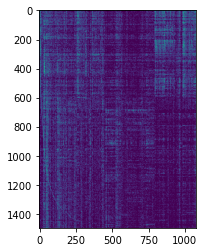

In [16]:
# Build matrix
import numpy as np

accuracy = np.zeros((len(pool.players), len(pool.maps)))
ps = np.zeros((len(pool.players), len(pool.maps)))
gs = np.zeros((len(pool.players), len(pool.maps)))
ms = np.zeros((len(pool.players), len(pool.maps)))

players_list = []
maps_list = []
maps_inv = {}

for (bid, mapData) in pool.maps.items():
    
    maps_list.append(mapData)
    maps_inv[bid] = len(maps_inv)
    
for (uid, player) in pool.players.items():
    
    for record in player["maps"]:
        accuracy[len(players_list), maps_inv[repr(record["bid"])]] = record["accuracy"]
        ps[len(players_list), maps_inv[repr(record["bid"])]] = record["p"]
        gs[len(players_list), maps_inv[repr(record["bid"])]] = record["g"]
        ms[len(players_list), maps_inv[repr(record["bid"])]] = record["m"]
    
    players_list.append(player)

from matplotlib import pyplot as plt
plt.imshow(accuracy)

In [17]:
for player in players_list:
    print("%s" % player['name'])

CreepyDuck
Lze
yassu-
POCARI SWEAT
1rori
HimekuriR18
fujisam
Ghost_r
Roger
zkane2
HEKUSODASU
owatanimal
Nekomusya7563
jyake
shoucan91
yea
JDrago14
imotoniku
Xin Leviathan
Fantazy
john571
hiyokokko
HarryAda
komasy
Acky_chinolover
kur4yam1
Six b0xes
Whulf
vodnanen
solros1101
9_9
paction
Reu70
ChurroChef
apfhd9898
Mikalodo
Maimaing
apaajaboleh10
elahen800
Senju-Muramasa
Jonah
Salimen
kalmlpv
Vanity8
Dynutka
LiLy1735
KZYS
Niro-
noct-arcadia
Articlle
kamakuraikusa
Ozu
KMYK_
kakeru2315
N-2yn
butter0414
C-light
Das
-Dusk
-Akitai-
Noyk_n
Genjuro
SilverTyrantX
Vulkin
Pare
baluxi4572
Faputa
Shamirin_mzk
dihidi
autumndayo
VestaraKhai48
kie
Mizuan-8x
Otaku9801
lukitsa124
Eyenine
sakakuxx
ilv_Rem
Rimazii
woog
_Rise
HiroK
iloveyou4ever
phosphene47
chayleaf
tzechi
Nozdormu
Cure
Minekuchi
L1ght
Servatory
hornedlove
XOlifreX
Lno
driodx
CrowWhite
OnosakiHito
Naverlyn
C5H10
Voltaeyx
beru
iTzzMar0
aarokoo
vysha
vizokaa
kiyozi11
stu00608
cacao
houraizin
oL0
7_7
L1va
nitori0
goheegy
kuroshishi16
ImChro
fruk

Likelihood is calculated in the sense that when Skill == Star, the expected outcome is 98.50% acc FC.
Two parameters: q => prob. for missing; p => prob. for 100s when not missing.
thus expected % of outcomes are - 300s (1-p)(1-q); 100s p(1-q); miss q

Exact binomial distributions are used for calculation.
<!-- Poisson distribution is used to calculate the likelihood as an approximation to binomials. -->

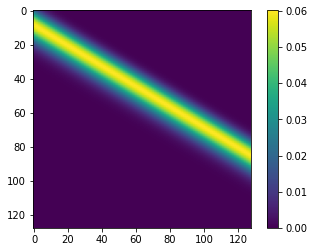

In [18]:
# I gave up so just gradient descent LUL
import torch

'''
torch source
def log_prob(self, value):
    if self._validate_args:
        self._validate_sample(value)
    log_factorial_n = torch.lgamma(self.total_count + 1)
    log_factorial_k = torch.lgamma(value + 1)
    log_factorial_nmk = torch.lgamma(self.total_count - value + 1)
    # k * log(p) + (n - k) * log(1 - p) = k * (log(p) - log(1 - p)) + n * log(1 - p)
    #     (case logit < 0)              = k * logit - n * log1p(e^logit)
    #     (case logit > 0)              = k * logit - n * (log(p) - log(1 - p)) + n * log(p)
    #                                   = k * logit - n * logit - n * log1p(e^-logit)
    #     (merge two cases)             = k * logit - n * max(logit, 0) - n * log1p(e^-|logit|)
    normalize_term = (self.total_count * _clamp_by_zero(self.logits)
                      + self.total_count * torch.log1p(torch.exp(-torch.abs(self.logits)))
                      - log_factorial_n)
    return value * self.logits - log_factorial_k - log_factorial_nmk - normalize_term
'''

import math

def _clamp_by_zero(x):
    # works like clamp(x, min=0) but has grad at 0 is 0.5
    return (x.clamp(min=0) + x - x.clamp(max=0)) / 2

# N    [       1, Nmaps]
# K    [Nplayers, Nmaps]
# logP [Nplayers, Nmaps]
def log_prob_binomial(N, K, logP):
    
    log_factorial_n = torch.lgamma(N + 1)
    log_factorial_k = torch.lgamma(K + 1)
    log_factorial_nmk = torch.lgamma(N - K + 1)
    
    normalize_term = (N * _clamp_by_zero(logP)
                      + N * torch.log1p(torch.exp(-torch.abs(logP)))
                      - log_factorial_n)
    
    return K * logP - log_factorial_k - log_factorial_nmk - normalize_term

# Log-Likelihood calculation
# TODO: Sparse optimization
def nll(skills, stars, notes, perfects, goods, misses, temp = 0.0):
    
    skills = skills.view(-1, 1)
    stars = stars.view(1, -1)
    
    signed_dist = stars - skills
    
    # 星数每比玩家强度高0.33, 玩家miss的概率就翻倍
    # 两者相等时miss率 = 0.001 (1000cb 1miss)
    logQ = math.log(0.001) + signed_dist * (1 / 0.333) * math.log(2.0)
    
    # 星数每比玩家强度高0.66, 玩家爆可的概率就翻倍
    # 两者相等时可率 = 0.02 (99% acc)
    logP = math.log(0.02) + signed_dist * (1 / 0.667) * math.log(2.0)
    
    # Misses
    miss_ll = log_prob_binomial(notes.unsqueeze(0), misses, logQ)
    
    # 100s
    good_ll = log_prob_binomial(notes.unsqueeze(0) - misses, goods, logP)
    
    # Total prob = product of misses and 100s (sum of their logarithms)
    nll = - good_ll - miss_ll
    
    return nll # [Nplayers, Nmaps]
    
# TODO: What is this visualization ...
test_skills = torch.linspace(5, 10, steps = 128)
test_stars = torch.linspace(5, 8, steps = 128)
preview = nll(test_skills, test_stars, torch.LongTensor([1000]), torch.LongTensor([985]), torch.LongTensor([15]), torch.LongTensor([0])) # 99.5% FC

# print(preview)

plt.imshow(torch.exp(-preview))
plt.colorbar()

In [19]:
# Fit the model

############## Initialzation

# Main matrix - accuracy
# M = torch.FloatTensor(accuracy)
P = torch.LongTensor(ps)
G = torch.LongTensor(gs)
M = torch.LongTensor(ms)

stars = np.asarray([i.difficulty_rating for i in maps_list])
avg_stars = stars.mean()

# Marginals
skills = torch.FloatTensor(np.random.normal(size = (len(pool.players),)) * 0.1 + avg_stars).requires_grad_() # Player skills
stars  = torch.FloatTensor(stars).requires_grad_() # Map stars
notes  = torch.LongTensor(np.asarray([i.max_combo for i in maps_list])) # Map max combo

_sk = skills

print(skills)
print(stars)

vis_steps = 100

# GPU GO
if True:
    
    device = torch.device('cuda:0')
    
    P = P.to(device)
    G = G.to(device)
    M = M.to(device)
    skills = skills.to(device).detach().requires_grad_()
    stars = stars.to(device).detach().requires_grad_()
    notes = notes.to(device)

# Optimizers
# optim_skills = torch.optim.SGD([skills], lr = 0.001, momentum = 0.9)
optim_skills = torch.optim.Adam([skills], lr = 0.001)
optim_stars = torch.optim.Adam([stars], lr = 0.001)
    
############## Iteration

# Initial value for skills (test)
for it in range(5000):
    
    total_nll = nll(skills, stars, notes, P, G, M)
    
    mean_nll = torch.masked_select(total_nll, (P > 0)).mean()
#     mean_nll = total_nll.mean()
#     mean_nll = skills.mean()
    
    optim_skills.zero_grad()
    mean_nll.backward()
#     print(_sk.grad.max())
    optim_skills.step()
    
    if it % vis_steps == 0:
        print("It %4d | %f" % (it, mean_nll))
        
# Alternating
alter_step = 250
for alter_it in range(10000):
    
    total_nll = nll(skills, stars, notes, P, G, M)
    
    mean_nll = torch.masked_select(total_nll, (P > 0)).mean()
    
    optim_skills.zero_grad()
    optim_stars.zero_grad()
    
    mean_nll.backward()
    
    if (alter_it // alter_step) % 2 == 0:
        optim_skills.step()
    else:
        optim_stars.step()
    
    if alter_it % vis_steps == 0:
        print("It %4d | %f" % (alter_it, mean_nll))

print(skills)

tensor([5.5764, 5.6233, 5.7202,  ..., 5.5767, 5.6787, 5.5549],
       requires_grad=True)
tensor([6.2200, 6.7700, 7.4200,  ..., 6.8900, 5.8400, 5.5400],
       requires_grad=True)
It    0 | 42.524071
It  100 | 38.069206
It  200 | 34.686382
It  300 | 32.080940
It  400 | 30.049587
It  500 | 28.451031
It  600 | 27.183929
It  700 | 26.173735
It  800 | 25.364458
It  900 | 24.713417
It 1000 | 24.187735
It 1100 | 23.761803
It 1200 | 23.415504
It 1300 | 23.132931
It 1400 | 22.901426
It 1500 | 22.710936
It 1600 | 22.553474
It 1700 | 22.422705
It 1800 | 22.313591
It 1900 | 22.222130
It 2000 | 22.145130
It 2100 | 22.080038
It 2200 | 22.024801
It 2300 | 21.977768
It 2400 | 21.937601
It 2500 | 21.903206
It 2600 | 21.873690
It 2700 | 21.848314
It 2800 | 21.826464
It 2900 | 21.807625
It 3000 | 21.791367
It 3100 | 21.777321
It 3200 | 21.765177
It 3300 | 21.754669
It 3400 | 21.745567
It 3500 | 21.737680
It 3600 | 21.730841
It 3700 | 21.724901
It 3800 | 21.719736
It 3900 | 21.715242
It 4000 | 21.711327


In [20]:
rank = np.argsort(skills.cpu().detach().numpy())[::-1]
for r, ix in enumerate(rank):
    print("#%3d %18s %f" % (r + 1, players_list[ix]['name'], skills[ix]))

#  1         MjIsMaster 10.921482
#  2         kevin3333g 10.768573
#  3            ganshie 10.483281
#  4            Saikoro 10.191745
#  5          Demiglace 9.673212
#  6            sing216 9.583937
#  7            huepike 9.464684
#  8             geston 9.273460
#  9            asgardv 9.072397
# 10             kuroru 8.643735
# 11              _yu68 8.510624
# 12              _Rise 8.346671
# 13              v2fax 8.272293
# 14        honehone567 8.207798
# 15             tsuba3 7.983402
# 16           Nekoharu 7.953182
# 17             Kobayu 7.850316
# 18                Mew 7.835895
# 19             Ku_Ren 7.624585
# 20          sed234rrr 7.606357
# 21              Maeda 7.558228
# 22           Leralice 7.527880
# 23         Tomoka Rin 7.521386
# 24       BlackHairEND 7.517151
# 25               MMzz 7.495765
# 26           Resutina 7.438441
# 27            Seren58 7.436705
# 28        Juuryoushin 7.422842
# 29         KiruTerina 7.413477
# 30             yassu- 7.410227
# 31  

In [21]:
xs = []
ys = []
ms = []

_s = stars.detach().cpu().numpy()

maprank = np.argsort(stars.cpu().detach().numpy())[::-1]
print("%120s | %8s <= Old SR" % ("Beatmap", "New"))
for r, ix in enumerate(maprank):
    bmap = maps_list[ix]
    mapName = "%s - %s [%s]" % (bmap.beatmapset.artist, bmap.beatmapset.title, bmap.version)
    print("%120s | %8.2f <= %4.2f" % (mapName, _s[ix], bmap.difficulty_rating))
    
    xs.append(float(bmap.difficulty_rating))
    ys.append(_s[ix])
    ms.append(bmap)

                                                                                                                 Beatmap |      New <= Old SR
                                                                   Lulickma - Thank You for Calling! [agu's Dial-Up Oni] |     8.32 <= 8.52
                                                                                     Kobaryo - New Game Plus [Game Over] |     8.06 <= 8.71
                                                                                           Filthy - Comfort BLAST [BOOM] |     8.03 <= 8.31
                                                                         Lulickma - Thank You for Calling! [Firce Force] |     7.93 <= 8.37
                                                                                       Laur - Terminal Missa [Missa Oni] |     7.90 <= 8.29
                                                                                     Kobaryo - Magical Sanctuary [Hakai] |     7.64 <= 8.29
                  

                                                                    ALiCE'S EMOTiON - Tag (Hardbeat Remix) [Wmf's Taiko] |     5.28 <= 4.79
                                                                                         PSYQUI - Education [Muzukashii] |     5.28 <= 4.48
                                                                               DECO*27 - Reversible Campaign [Inner Oni] |     5.27 <= 5.07
                                                                           Omoi - Snow Drive (01.23) [Capu's Muzukashii] |     5.27 <= 4.26
                                                                                    ClariS - Connect -TV MIX- [MM's Oni] |     5.26 <= 4.40
                                                                                              nano - MY LIBERATION [Oni] |     5.26 <= 4.69
                                                  UNDEAD CORPORATION - Yoru Naku Usagi wa Yume wo Miru [jom's Taiko Oni] |     5.26 <= 5.19
                    

In [24]:
# plotly
import plotly.express as px
import pandas as pd

data = {
    'Old SR': xs, 
    'New diff': ys, 
    'Name': ["%s - %s [%s]" % (m.beatmapset.artist, m.beatmapset.title, m.version) for m in ms],
    'OD': [m.accuracy for m in ms],
    'totalPC': [m.playcount for m in ms],
}
df = pd.DataFrame(data)

fig = px.scatter(df, x = 'Old SR', y = 'New diff', hover_data = ['Name', 'Old SR', 'totalPC', 'OD', 'New diff'])
fig.show()

In [ ]:
# # Make public
# import chart_studio.plotly as py
# py.plot(fig, filename = 'SR^2 Expr2', auto_open=True)